#  A Glimpse Into Self-Reported Health Inaccuracies: How Demographics and Diet Influence Personal Perception of Well-Being


# **Part 1:** Introduction

In today's data-driven world, leveraging advanced analytics has become a valuable means of deciphering subtle patterns and insights within the healthcare industry. This project seeks to explore these possibilities, applied to a vast [dataset on cardiovascular disease (CVD)](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset), containing records of patients with diverse lifestyles, habits, and diseases.

Our aim is to explore the relationships embedded in this data, in turn answering questions like:


*   How well do patient lifestyles predict their risk of disease?
*   What correlations exist between personal habits, physiological traits, and disease?
*   How well can machine learning models evaluate patient disease outcomes based on self-reported lifestyles?

Additional data on worldwide disease and mortality was combined with CVD data to define multiple custom health metrics. These were used to compare an objective measure of health against patient self-evaluation, and to reveal insights into how accurate patients were in perceiving their own health.

Finally, a variety of predictive modeling techniques were applied, evaluated, and compared against each other to shed light on the potential of machine learning in the healthcare industry.

The project demonstrates the powerful ability of robust predictive models in healthcare. Integration of these kinds of data-driven insights can streamline a multitude of critical aspects, such as hospital productivity, resource allocation, and physician decision making, paving the path toward better healthcare, and a better tomorrow.




# **Part 2:** Data Loading

In this section, we import, download and otherwise set up all of the necessary packages and data for this project.

## **2.1** Installing Packages
Here, we import all relevant libraries for all aspects of the project. This includes libraries such as pandas, matplotlib, numpy, seaborn, pandasql, and scikit-learn.

In [ ]:
!pip install sqlalchemy==1.4.46
!pip install pandasql

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=8cc3fa09c3ed64af115d162062c3b49b23ff2fd2aac16010cbf012efb29f8bf4
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import pandasql as ps #SQL on Pandas Dataframe
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import boxcox
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from xgboost import XGBRegressor
from folium.plugins import HeatMap
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import spearmanr
from sklearn import datasets, linear_model, svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.utils import data as data_utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

## **2.2** Setting Up Kaggle

Here, we complete all necessary tasks to set up loading our database from Kaggle.

In [ ]:
%%capture
!apt update
!pip install kaggle

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the kaggle directory
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
# Download datasets
!!kaggle datasets download -d alphiree/cardiovascular-diseases-risk-prediction-dataset
!!kaggle datasets download -d imtkaggleteam/causes-of-death-in-world
!!kaggle datasets download -d alitaqi000/global-population-trends2016-2022
!!kaggle datasets download -d iamsouravbanerjee/cause-of-deaths-around-the-world

['Downloading cause-of-deaths-around-the-world.zip to /content',
 '',
 '  0% 0.00/324k [00:00<?, ?B/s]',
 '',
 '100% 324k/324k [00:00<00:00, 109MB/s]']

In [ ]:
# Unzip folder in Colab content folder
!unzip /content/cardiovascular-diseases-risk-prediction-dataset.zip
!unzip /content/causes-of-death-in-world
!unzip /content/cause-of-deaths-around-the-world
!unzip /content/global-population-trends2016-2022

Archive:  /content/cardiovascular-diseases-risk-prediction-dataset.zip
  inflating: CVD_cleaned.csv         
Archive:  /content/causes-of-death-in-world.zip
  inflating: 1- total-deaths-comparison.csv  
  inflating: 2- share-of-deaths-from-major-causes.csv  
  inflating: 3- age-standardized-deaths-from-all-causes.csv  
  inflating: 4- cancer-death-rate-who-mdb.csv  
  inflating: 5- respiratory-infection-death-rate-who-mdb.csv  
  inflating: 6- infectious-and-parasitic-diseases-death-rate-who-mdb.csv  
  inflating: 7- death-rate-from-communicable-vs-non-communicable-diseases.csv  
  inflating: 8- cardiovascular-disease-death-rate-who-mdb.csv  
Archive:  /content/cause-of-deaths-around-the-world.zip
  inflating: cause_of_deaths.csv     
Archive:  /content/global-population-trends2016-2022.zip
  inflating: Global Population Trends(2016-2022).csv  


# **Part 3:** Cleaning of Cardiovascular Disease Dataset

In this section, we took our first look at the primary dataset to understand structure, datatype and more. We then cleaned, wrangled and encoded the data to suit our expected needs. Finally, we devised our own engineered columns to enhance the further stages of EDA (Part 5) and ultimately model design (Part 6-7).

## **3.1** Cardiovascular Dataset Data Structure

### 3.1.1 General Dataset Information

First, we wanted to get a general sense of our data and determine general tendencies. We did so by getting a summary of the critical characteristics of dataset.

In [ ]:
# Look at descriptive statistics
cvd_df = pd.read_csv('CVD_cleaned.csv')
cvd_df.describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


These results demonstrated two key takeaways about the population of people considered in this dataset:
* Median BMI was 27.44
> After doing some research, we learned that the usual healthy range for BMI in adults is 18.5 – 24.9. Additionaly, a BMI of 27.44 would be classified as overweight. This suggested to us that our population had a slight overweight skew. Interestingly, the average BMI in the United States is 26.5. This finding suggests that not only is this data set skewed towards overweight, it does so in a manner that might not reflect the actual population.

* Median fruit and vegetable consumption were also lower than expected at 12 and 30 respectively
> Even though there is no objective number to compare 12 and 30 with, This number still felt quite minimual considering the fact that these values are on scales of 128 and 120, respectively. This falls in line with recent studies that document that low fruit and vegetable intake in the US.

[Source](https://www.cdc.gov/nchs/data/nhanes/databriefs/adultweight.pdf)

In [ ]:
# Understand datatypes
cvd_df.dtypes

General_Health                   object
Checkup                          object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
dtype: object

In [ ]:
# Look at head
cvd_df.head(10)

,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0
5,Good,Within the past year,No,No,No,No,Yes,No,Yes,Male,60-64,183.0,154.22,46.11,No,0.0,12.0,12.0,12.0
6,Fair,Within the past year,Yes,Yes,No,No,No,No,Yes,Male,60-64,175.0,69.85,22.74,Yes,0.0,16.0,8.0,0.0
7,Good,Within the past year,Yes,No,No,No,No,No,Yes,Female,65-69,165.0,108.86,39.94,Yes,3.0,30.0,8.0,8.0
8,Fair,Within the past year,No,No,No,No,Yes,No,No,Female,65-69,163.0,72.57,27.46,Yes,0.0,12.0,12.0,4.0
9,Fair,Within the past year,No,No,No,No,No,Yes,Yes,Female,70-74,163.0,91.63,34.67,No,0.0,12.0,12.0,1.0


On first glance, we noticed an that the individual on row index two rated their own health as "very good" despite having diabetes, a BMI that qualifies as obese, and dietary habits high in fried potatoes/low in greens. This made us curious about the veracity of self reported general health, which we examined further later on and ultimately became the focus of our project!

We then checked for nulls (there weren't any!)

In [ ]:
# Print the number of nulls
print(cvd_df.isnull().sum().sum())

0


### 3.1.2 Exploring individual column distributions

We then noticed from the head of the table that several columns took the form of string categorical data, so each one was isolated to find all unique values, which informed our future decisions in pre-processing (3.2).

In [ ]:
# Print unique options
print(cvd_df['General_Health'].unique())
print(cvd_df['Checkup'].unique())
print(cvd_df['Exercise'].unique())
print(cvd_df['Heart_Disease'].unique())
print(cvd_df['Skin_Cancer'].unique())
print(cvd_df['Other_Cancer'].unique())
print(cvd_df['Depression'].unique())
print(cvd_df['Diabetes'].unique())
print(cvd_df['Arthritis'].unique())
print(cvd_df['Sex'].unique())
print(cvd_df['Age_Category'].unique())
print(cvd_df['Smoking_History'].unique())

['Poor' 'Very Good' 'Good' 'Fair' 'Excellent']
['Within the past 2 years' 'Within the past year' '5 or more years ago'
 'Within the past 5 years' 'Never']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but female told only during pregnancy']
['Yes' 'No']
['Female' 'Male']
['70-74' '60-64' '75-79' '80+' '65-69' '50-54' '45-49' '18-24' '30-34'
 '55-59' '35-39' '40-44' '25-29']
['Yes' 'No']


Then, to better understand the distribution of each category, Counters were used to see how many rows corresponded to each label.

In [ ]:
# Look at number of elements per class!
print(Counter(cvd_df['General_Health']))
print(Counter(cvd_df['Checkup']))
print(Counter(cvd_df['Exercise']))
print(Counter(cvd_df['Heart_Disease']))
print(Counter(cvd_df['Skin_Cancer']))
print(Counter(cvd_df['Other_Cancer']))
print(Counter(cvd_df['Depression']))
print(Counter(cvd_df['Diabetes']))
print(Counter(cvd_df['Arthritis']))
print(Counter(cvd_df['Sex']))
print(Counter(cvd_df['Age_Category']))
print(Counter(cvd_df['Smoking_History']))

Counter({'Very Good': 110395, 'Good': 95364, 'Excellent': 55954, 'Fair': 35810, 'Poor': 11331})
Counter({'Within the past year': 239371, 'Within the past 2 years': 37213, 'Within the past 5 years': 17442, '5 or more years ago': 13421, 'Never': 1407})
Counter({'Yes': 239381, 'No': 69473})
Counter({'No': 283883, 'Yes': 24971})
Counter({'No': 278860, 'Yes': 29994})
Counter({'No': 278976, 'Yes': 29878})
Counter({'No': 246953, 'Yes': 61901})
Counter({'No': 259141, 'Yes': 40171, 'No, pre-diabetes or borderline diabetes': 6896, 'Yes, but female told only during pregnancy': 2646})
Counter({'No': 207783, 'Yes': 101071})
Counter({'Female': 160196, 'Male': 148658})
Counter({'65-69': 33434, '60-64': 32418, '70-74': 31103, '55-59': 28054, '50-54': 25097, '80+': 22271, '40-44': 21595, '45-49': 20968, '75-79': 20705, '35-39': 20606, '18-24': 18681, '30-34': 18428, '25-29': 15494})
Counter({'No': 183590, 'Yes': 125264})


There were noticable discrepancies in the distribution of the data, such as the amount of people who did/didn't exercise regularly. This motivated the use of balancing techniques such as downsampling, in section 5.3.1. Visualizations of these unbalanced distributions are graphed below:

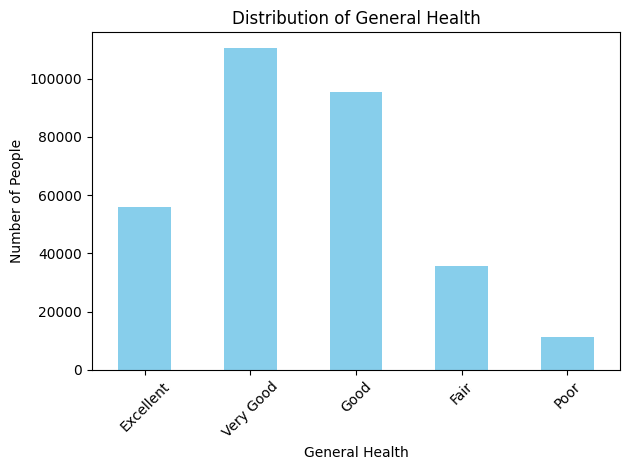

In [ ]:
# Visualiztion of the distribution of "General Health" (self-evaluated)
general_health_counts = cvd_df['General_Health'].value_counts()

category_order = ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']

general_health_counts = general_health_counts.reindex(category_order)

general_health_counts.plot(kind='bar', color='skyblue')
plt.xlabel('General Health')
plt.ylabel('Number of People')
plt.title('Distribution of General Health')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

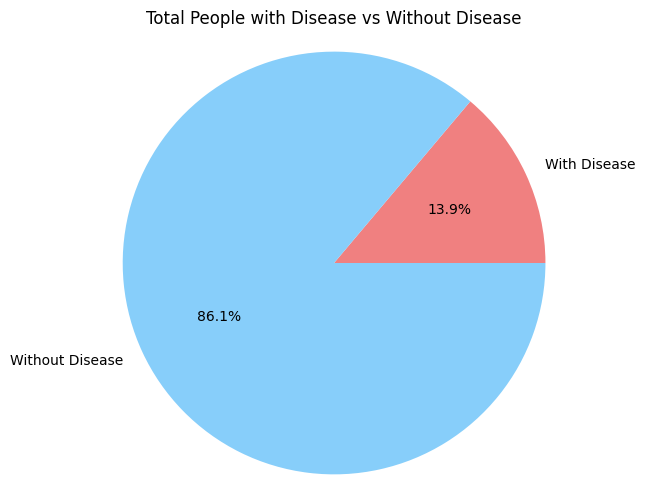

In [ ]:
# Visualiztion of the distribution of disease across all patients.
disease_columns = ['Heart_Disease', 'Depression', 'Diabetes']

total_with_disease = cvd_df[disease_columns].apply(lambda x: (x == 'Yes').sum()).sum()
total_without_disease = cvd_df[disease_columns].apply(lambda x: (x == 'No').sum()).sum()

labels = ['With Disease', 'Without Disease']
sizes = [total_with_disease, total_without_disease]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Total People with Disease vs Without Disease')
plt.show()

These graphs underscore a few majorities within the data that cause uneven distribution in the data set.

### 3.1.3 Dropping insignificant columns

We decided to drop `Checkup` because of the very clear skew towards people having had a checkup in the past year. Thus, we felt it would be hard to make conclusions about the relationship between this column and others.

In [ ]:
cvd_df = cvd_df.drop(columns=["Checkup"])

We decided to drop `Arthritis` as well, because this feature was decidedly less cardiovascular/diet related than the other disease states. This decision was made in consultation with our own experience in biology classes as well as friends/family members in medicine.

In [ ]:
cvd_df = cvd_df.drop(columns=["Arthritis"])

The other columns were all kept because we hoped to gain a holistic understanding of how well self-reportable factors such as diet/demographics could contribute to disease prediction in several cases. These findings were necessary to compare to how well the same data could predict the more subjective self-reported **measure** of `General_Health`.

## **3.2** Pre-processing CVD Dataset

### 3.2.1 Datatype Wrangling + Encoding

In this section, we converted necessary datatypes to numeric values. We also dropped/merged unnecessary columns.

All columns to be used as features were converted into numeric types, while targets were left as is to be predicted. Note that we did not use One-Hot Encoding because each of the variables was decided to be ordinal in some sense.

Features included all self-reportable demographic columns and diet columns, targets included diseases and `General_Health`.

Feature columns: `Exercise`, `Sex`, `Age_Category`, `Height_(cm)`, `Weight_(kg)`, `BMI`, `Smoking_History`, `Alcohol_Consumption`, `Fruit_Consumption`, `Green_Vegetables_Consumption`, `FriedPotato_Consumption`.

Target columns: `Heart_Disease`, `Skin_Cancer`, `Other_Cancer`, `Depression`, `Diabetes`, `General_Health`.

In [ ]:
# One-Hot Encode the sex, exercise and smoking history columns
cvd_df['Exercise'] = cvd_df['Exercise'].apply(lambda x : 1 if 'Yes' in x else 0)
cvd_df['Smoking_History'] = cvd_df['Smoking_History'].apply(lambda x : 1 if 'Yes' in x else 0)
cvd_df['Sex'] = cvd_df['Sex'].apply(lambda x : 1 if 'Female' in x else 0)

To use `age_categories` as a numerical features later on, the string labels were mapped to integers in order from youngest to oldest. This engineered field is used for linearity later on (as opposed to a categorical variable).

In [ ]:
# Define mapping of age catergories to numerical values
age_categories = {
    '18-24': 0, '25-29': 1,
    '30-34': 2, '35-39': 3,
    '40-44': 4, '45-49': 5,
    '50-54': 6, '55-59': 7,
    '60-64': 8, '65-69': 9,
    '70-74': 10, '75-79': 11,
    '80+': 12
}

# Fix age categories to be numerical using lambda function
cvd_df['Age_Category_Num'] = cvd_df['Age_Category'].apply(lambda x : age_categories[x])

Similarly, in order to gain a numerical representation of `General Health` for linear regression purposes later on (rather than logistic), the string labels were mapped to integers in order from 'Poor' to 'Very Good'.

In [ ]:
# Define mapping of age catergories to numerical values
genhealth_categories = {
    'Poor': 5,
    'Fair': 4,
    'Good': 3,
    'Very Good': 2,
    'Excellent': 1,
}

# Fix age categories to be numerical using lambda function
cvd_df['General_Health_Num'] = cvd_df['General_Health'].apply(lambda x : genhealth_categories[x])

For feature engineering later on, the non-numeric disease states were also converted into numeric values. Most notably, for diabetes this was binarized based on whether the category contained "Yes" or "No" in order to simplify the calculation. These non-strict categories made up a smaller proportion of the dataset to begin with, so the effects of this decision was decided to be relatively trivial.

In [ ]:
cvd_df['Diabetes_Num'] = cvd_df['Diabetes'].apply(lambda x : 1 if 'Yes' in x else 0)
cvd_df['Skin_Cancer_Num'] = cvd_df['Skin_Cancer'].apply(lambda x : 1 if 'Yes' in x else 0)
cvd_df['Other_Cancer_Num'] = cvd_df['Other_Cancer'].apply(lambda x : 1 if 'Yes' in x else 0)
cvd_df['Heart_Disease_Num'] = cvd_df['Heart_Disease'].apply(lambda x : 1 if 'Yes' in x else 0)

Finally, the two cancer columns were combined into 1 and converted into numeric values just like with `Diabetes` and `Heart_Disease`.

In [ ]:
cvd_df['Cancer'] = (cvd_df['Skin_Cancer_Num'] + cvd_df['Other_Cancer_Num']).apply(lambda x : 'No' if x == 0 else 'Yes')
cvd_df['Cancer_Num'] = cvd_df['Cancer'].apply(lambda x : 1 if 'Yes' in x else 0)

# Drop the extra columns
cvd_df = cvd_df.drop(columns=['Skin_Cancer_Num','Skin_Cancer','Other_Cancer_Num','Other_Cancer'])

### 3.2.2 Feature Engineering

In this section, two additional features were engineered to contribute to future analyses. These were `Dietary Metric`, based on diet, and `General_Health_Metric`, an objective health metric we derive later in the notebook.

Firstly, the dietary fields were combined to engineer a single dietary metric. `Dietary_Metric` was defined to be (`Fruit_Consumption` + `Green_Vegetables_Consumption`) - (`Alcohol_Consumption` + `FriedPotatoConsumption`). This metric is investigated further later on.

In [ ]:
cvd_df['Dietary_Metric'] = (cvd_df['Fruit_Consumption'] + \
                        cvd_df['Green_Vegetables_Consumption'])- \
                         (cvd_df['Alcohol_Consumption'] + \
                          cvd_df['FriedPotato_Consumption'])

Below is a histogram showing the distribution of the "dietary metric" across all patients:


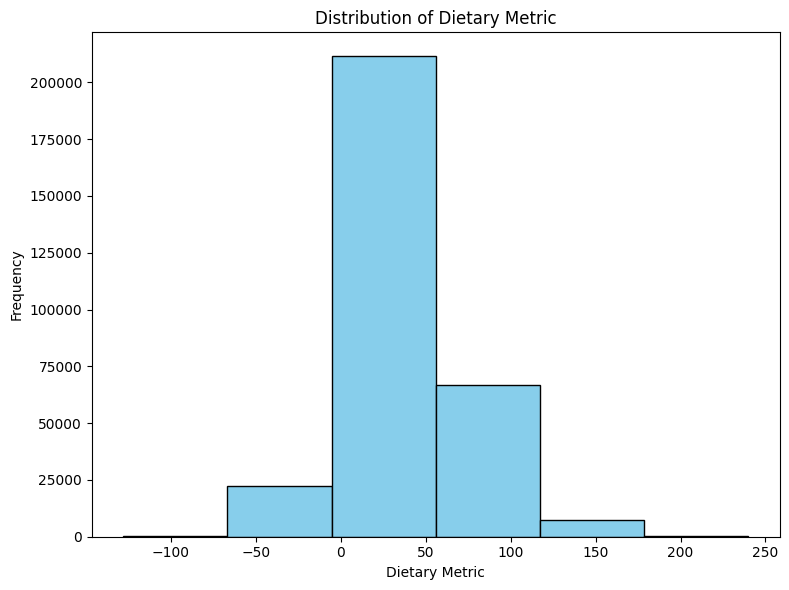

In [ ]:
dietary_metric_min = cvd_df['Dietary_Metric'].min()
dietary_metric_max = cvd_df['Dietary_Metric'].max()
dietary_metric_range = dietary_metric_max - dietary_metric_min

plt.figure(figsize=(8, 6))
plt.hist(cvd_df['Dietary_Metric'], bins=6, range=(dietary_metric_min, dietary_metric_max), color='skyblue', edgecolor='black')
plt.xlabel('Dietary Metric')
plt.ylabel('Frequency')
plt.title('Distribution of Dietary Metric')
plt.tight_layout()
plt.show()

Similarly, the disease fields were combined to engineer an "objective" measure of general health. This measure of general health was designed based on the analysis of four "helper datasets". The processing and analysis of these datasets is described at depth in Part 4, but it essentially weights the presence/absence of disease class based on its contribution to mortality around the world. Obviously, mortality and general health are not directly correlated, but we felt that this was the best method of extracting an objective ground truth for our purposes.

We place these metrics on a Gaussian distribution to accurately represent the distribution of self-reported metrics. Then, we linearly map these values to a value from 1 to 5 in order to match the range of `General_Health_Num`, and calculate the column `SelfReport_Inaccuracy`.

In [ ]:
# Define the mapping coefficients
coeff_diabetes = 0.084073
coeff_cancer = 0.335078
coeff_heart_disease = 0.580848

cvd_df['General_Health_Metric'] = (
    coeff_diabetes * cvd_df['Diabetes_Num'] +
    coeff_cancer * cvd_df['Cancer_Num'] +
    coeff_heart_disease * cvd_df['Heart_Disease_Num']
)

# Apply Box-Cox transformation to make the data more Gaussian-like
cvd_df['General_Health_Metric'], _ = boxcox(cvd_df['General_Health_Metric'] + 1)  # Adding 1 to handle zero values

# Rescale to the range 1-5
min_val_transformed = cvd_df['General_Health_Metric'].min()
max_val_transformed = cvd_df['General_Health_Metric'].max()

cvd_df['General_Health_Metric'] = (
    (cvd_df['General_Health_Metric'] - min_val_transformed) /
    (max_val_transformed - min_val_transformed)
) * (5 - 1) + 1

# Calculate SelfReport_Inaccuracy
cvd_df['SelfReport_Inaccuracy'] = cvd_df['General_Health_Num'] - cvd_df['General_Health_Metric']

cvd_df

,General_Health,Exercise,Heart_Disease,Depression,Diabetes,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,...,FriedPotato_Consumption,Age_Category_Num,General_Health_Num,Diabetes_Num,Heart_Disease_Num,Cancer,Cancer_Num,Dietary_Metric,General_Health_Metric,SelfReport_Inaccuracy
0,Poor,0,No,No,No,1,70-74,150.0,32.66,14.54,...,12.0,10,5,0,0,No,0,34.0,1.000000,4.000000
1,Very Good,0,Yes,No,Yes,1,70-74,165.0,77.11,28.29,...,4.0,10,2,1,1,No,0,26.0,4.961895,-2.961895
2,Very Good,1,No,No,Yes,1,60-64,163.0,88.45,33.47,...,16.0,8,2,1,0,No,0,-5.0,3.021197,-1.021197
3,Poor,1,Yes,No,Yes,0,75-79,180.0,93.44,28.73,...,8.0,11,5,1,1,No,0,52.0,4.961895,0.038105
4,Good,0,No,No,No,0,80+,191.0,88.45,24.37,...,0.0,12,3,0,0,No,0,12.0,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308849,Very Good,1,No,No,No,0,25-29,168.0,81.65,29.05,...,0.0,1,2,0,0,No,0,34.0,1.000000,1.000000
308850,Fair,1,No,No,Yes,0,65-69,180.0,69.85,21.48,...,4.0,9,4,1,0,No,0,63.0,3.021197,0.978803
308851,Very Good,1,No,Yes,"Yes, but female told only during pregnancy",1,30-34,157.0,61.23,24.69,...,4.0,2,2,1,0,No,0,40.0,3.021197,-1.021197
308852,Very Good,1,No,No,No,0,65-69,183.0,79.38,23.73,...,0.0,9,2,0,0,No,0,39.0,1.000000,1.000000


Similar to dietary metric, we created a histogram for general health metric, and also self report inaccuracy.



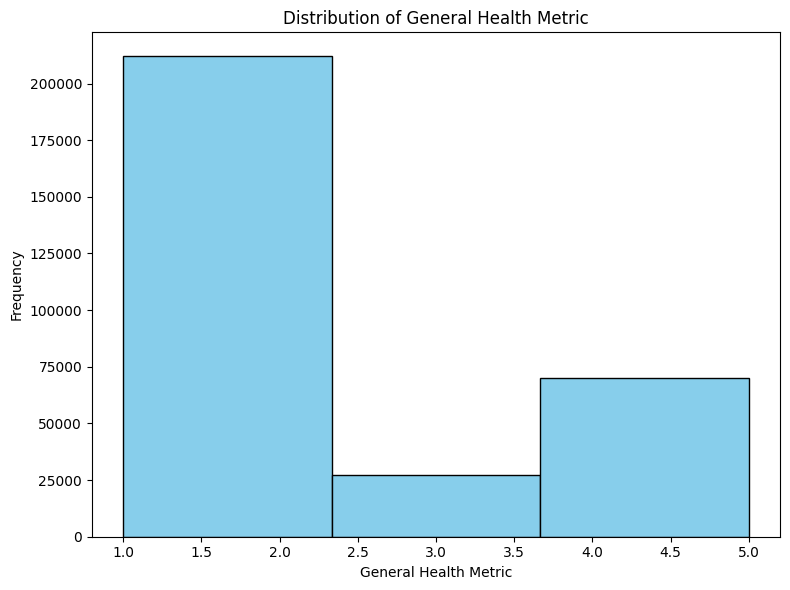

In [ ]:
general_metric_min = cvd_df['General_Health_Metric'].min()
general_metric_max = cvd_df['General_Health_Metric'].max()
general_metric_range = general_metric_max - general_metric_min

plt.figure(figsize=(8, 6))
plt.hist(cvd_df['General_Health_Metric'], bins=3, range=(general_metric_min, general_metric_max), color='skyblue', edgecolor='black')
plt.xlabel('General Health Metric')
plt.ylabel('Frequency')
plt.title('Distribution of General Health Metric')
plt.tight_layout()
plt.show()

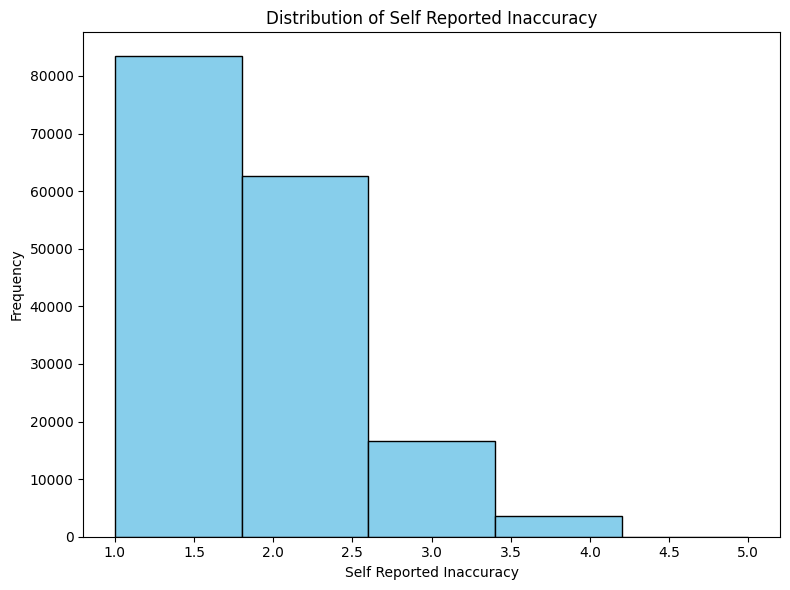

In [ ]:
inaccuracy_min = cvd_df['SelfReport_Inaccuracy'].min()
inaccuracy_max = cvd_df['SelfReport_Inaccuracy'].max()
inaccuracy_range = inaccuracy_max - inaccuracy_min

plt.figure(figsize=(8, 6))
plt.hist(cvd_df['SelfReport_Inaccuracy'], bins=5, range=(general_metric_min, general_metric_max), color='skyblue', edgecolor='black')
plt.xlabel('Self Reported Inaccuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Self Reported Inaccuracy')
plt.tight_layout()
plt.show()

From the histograms, we can see that most people have a relatively lower "general health metric", meaning a lower presence of disease. Most people also have a lower self-reported inaccuracy, meaning overall, people predicted their own health decently well, but it is also seen that some were far off, in the tail of the histogram.

# **Part 4:** Preprocessing & Analysis of Helper Datasets

As previously mentioned, these datasets ([Dataset 1](https://www.kaggle.com/datasets/imtkaggleteam/causes-of-death-in-world?select=8-+cardiovascular-disease-death-rate-who-mdb.csv), [Dataset 2](https://www.kaggle.com/datasets/alitaqi000/global-population-trends2016-2022?select=Global+Population+Trends%282016-2022%29.csv), [Dataset 3](https://www.kaggle.com/datasets/iamsouravbanerjee/cause-of-deaths-around-the-world)) are used to help generate a more objective metric of "General Health" as determined by the various disease states including the Cardiovascular Dataset. In order to do this, population data and mortality rates of diabetes, cancer, and heart disease were accumulated from various sources and averaged across various times and places to get a global view of the significance of each one to overall mortality. Weightings for 3.2.2 were determined relative to these mortality findings.

Note: the data here is not based on the number of people *with the disease* who died from the disease but rather the *total number of people* who died from the disease. However, because preliminary research found that each of the main 3 categories was similarly highly prevalent (5-10% of the US population), this difference was not considered in the weightings.

## **4.1** Helper Dataset Structure + Processing

### 4.1.1 Features and structures of the datasets

In this section, we simply look at the descriptive statistics and datatypes of the datasets.

In [ ]:
# Look at descriptive statistics
population_df = pd.read_csv('Global Population Trends(2016-2022).csv')
population_df.describe()

,Year,Birth Rate,Death Rate
count,1073.000000,1073.000000,1073.000000
mean,2019.013048,18.801519,7.841907
std,1.410190,9.903449,2.973418
min,2017.000000,0.000000,0.000000
25%,2018.000000,10.620000,6.067000
50%,2019.000000,16.025000,7.396000
75%,2020.000000,25.921000,9.313000
max,2021.000000,46.351000,21.700000


In [ ]:
cod_df = pd.read_csv('cause_of_deaths.csv')
cod_df.describe()

,Year,Meningitis,Alzheimer's Disease and Other Dementias,Parkinson's Disease,Nutritional Deficiencies,Malaria,Drowning,Interpersonal Violence,Maternal Disorders,HIV/AIDS,...,Diabetes Mellitus,Chronic Kidney Disease,Poisonings,Protein-Energy Malnutrition,Road Injuries,Chronic Respiratory Diseases,Cirrhosis and Other Chronic Liver Diseases,Digestive Diseases,"Fire, Heat, and Hot Substances",Acute Hepatitis
count,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,...,6120.000000,6120.000000,6120.000000,6120.000000,6120.000000,6.120000e+03,6120.000000,6120.000000,6120.000000,6120.000000
mean,2004.500000,1719.701307,4864.189379,1173.169118,2253.600000,4140.960131,1683.333170,2083.797222,1262.589216,5941.898529,...,5138.704575,4724.132680,425.013399,1965.994281,5930.795588,1.709237e+04,6124.072059,10725.267157,588.711438,618.429902
std,8.656149,6672.006930,18220.659072,4616.156238,10483.633601,18427.753137,8877.018366,6917.006075,6057.973183,21011.962487,...,16773.081040,16470.429969,2022.640521,8255.999063,24097.784291,1.051572e+05,20688.118580,37228.051096,2128.595120,4186.023497
min,1990.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1997.000000,15.000000,90.000000,27.000000,9.000000,0.000000,34.000000,40.000000,5.000000,11.000000,...,236.000000,145.750000,6.000000,5.000000,174.750000,2.890000e+02,154.000000,284.000000,17.000000,2.000000
50%,2004.500000,109.000000,666.500000,164.000000,119.000000,0.000000,177.000000,265.000000,54.000000,136.000000,...,1087.000000,822.000000,52.500000,92.000000,966.500000,1.689000e+03,1210.000000,2185.000000,126.000000,15.000000
75%,2012.000000,847.250000,2456.250000,609.250000,1167.250000,393.000000,698.000000,877.000000,734.000000,1879.000000,...,2954.000000,2922.500000,254.000000,1042.500000,3435.250000,5.249750e+03,3547.250000,6080.000000,450.000000,160.000000
max,2019.000000,98358.000000,320715.000000,76990.000000,268223.000000,280604.000000,153773.000000,69640.000000,107929.000000,305491.000000,...,273089.000000,222922.000000,30883.000000,202241.000000,329237.000000,1.366039e+06,270037.000000,464914.000000,25876.000000,64305.000000


In [ ]:
cancer_death_df = pd.read_csv('4- cancer-death-rate-who-mdb.csv')
cancer_death_df.describe()

,Year,"Age-standardized deaths that are from malignant neoplasms per 100,000 people, in both sexes aged all ages"
count,4707.000000,4707.000000
mean,1992.653070,118.910591
std,18.181654,35.961109
min,1950.000000,0.000000
25%,1979.000000,93.978285
50%,1995.000000,123.202190
75%,2008.000000,144.982685
max,2021.000000,224.111190


In [ ]:
cvd_death_df = pd.read_csv('8- cardiovascular-disease-death-rate-who-mdb.csv')
cvd_death_df.describe()

,Year,"Age-standardized deaths that are from cardiovascular diseases per 100,000 people, in both sexes aged all ages"
count,4707.000000,4707.000000
mean,1992.653070,283.459554
std,18.181654,137.331332
min,1950.000000,31.486345
25%,1979.000000,168.259805
50%,1995.000000,266.469670
75%,2008.000000,385.163605
max,2021.000000,944.720800


In [ ]:
# Understand datatypes
print(population_df.dtypes)
print(cod_df.dtypes)
print(cancer_death_df.dtypes)
print(cvd_death_df.dtypes)

Country                   object
Year                       int64
Total Population          object
Urban Population          object
Rural Population          object
Population Density        object
Life Expectancy           object
Birth Rate               float64
Death Rate               float64
Fertility Rate            object
Infant Mortality Rate     object
Growth Rate               object
dtype: object
Country/Territory                             object
Code                                          object
Year                                           int64
Meningitis                                     int64
Alzheimer's Disease and Other Dementias        int64
Parkinson's Disease                            int64
Nutritional Deficiencies                       int64
Malaria                                        int64
Drowning                                       int64
Interpersonal Violence                         int64
Maternal Disorders                             int64
HIV/AID

### 4.1.2 Cleaning the Datasets for Analysis

Here, we isolate the columns of interest, clean any incorrectly typed columns, and deal with null values.

In [ ]:
# Keep only the columns of interest
population_df = population_df[['Country','Year','Total Population']]
population_df.head()

,Country,Year,Total Population
0,Afghanistan,2017,-
1,Afghanistan,2018,"36,686,784"
2,Afghanistan,2019,"37,769,499"
3,Afghanistan,2020,"38,972,230"
4,Afghanistan,2021,"40,099,462"


Clearly, some rows have non-numeric values and these rows are dropped, while the rest are converted to numeric.

In [ ]:
population_df = population_df[population_df['Total Population'] != '-']

population_df['Total Population'] = population_df['Total Population'].apply(lambda x : x.replace(',','')).astype(int)

population_df.head()

,Country,Year,Total Population
1,Afghanistan,2018,36686784
2,Afghanistan,2019,37769499
3,Afghanistan,2020,38972230
4,Afghanistan,2021,40099462
6,Albania,2018,2866376


In [ ]:
# Isolate columns of interest, then look at head
cod_df = cod_df[['Country/Territory','Year','Diabetes Mellitus']]
cod_df.head()

,Country/Territory,Year,Diabetes Mellitus
0,Afghanistan,1990,2108
1,Afghanistan,1991,2120
2,Afghanistan,1992,2153
3,Afghanistan,1993,2195
4,Afghanistan,1994,2231


In [ ]:
# Look at head
cancer_death_df.head()

,Entity,Code,Year,"Age-standardized deaths that are from malignant neoplasms per 100,000 people, in both sexes aged all ages"
0,Albania,ALB,1987,88.860980
1,Albania,ALB,1988,99.332530
2,Albania,ALB,1989,92.817200
3,Albania,ALB,1992,74.528990
4,Albania,ALB,1993,66.275505


In [ ]:
# Look at head
cvd_death_df.head()

,Entity,Code,Year,"Age-standardized deaths that are from cardiovascular diseases per 100,000 people, in both sexes aged all ages"
0,Albania,ALB,1987,331.37842
1,Albania,ALB,1988,333.62150
2,Albania,ALB,1989,339.13010
3,Albania,ALB,1992,289.65850
4,Albania,ALB,1993,264.37045


We then checked for nulls (there weren't any!)

In [ ]:
# Print the number of nulls
print(population_df.isnull().sum().sum())
print(cod_df.isnull().sum().sum())
print(cancer_death_df.isnull().sum().sum())
print(cvd_death_df.isnull().sum().sum())

0
0
0
0


## **4.2** Helper Dataset Preprocessing

In this section, the four datasets are merged together in order to make mortality rate calculations consistent. Then, they are averaged together by location to obtain a singular dataframe.

### 4.2.1 Keeping Mortality Rates Consistent

First, because the death counts for cancer and heart disease were calculated per 100,000 people, diabetes deaths were also calculated to be per 100,000 people. This was done by joining the first two dataframes and calculating another column.

In [ ]:
query = '''
SELECT p.Country, p.Year,
  100000*CAST(c.[Diabetes Mellitus] AS FLOAT)/CAST(p.[Total Population] AS FLOAT)
    AS "Diabetes_Deaths"
FROM population_df as p
  JOIN cod_df as c
    ON p.Country == c.[Country/Territory]
      AND p.Year == c.Year
ORDER BY p.Country ASC
'''
diabetes_death_df = ps.sqldf(query, locals())
diabetes_death_df.head()

,Country,Year,Diabetes_Deaths
0,Afghanistan,2018,12.713025
1,Afghanistan,2019,12.753677
2,Albania,2018,5.930834
3,Albania,2019,6.131335
4,Algeria,2018,12.147302


### 4.2.2 Merging All Metrics

Then, we joined all of the datasets together by country and year, then averaged data by country (over all years), then averaged data worldwide (over all countries).

In [ ]:
query = '''
WITH combined AS (
  SELECT
    c.Entity,
    c.Year,
    c.[Age-standardized deaths that are from malignant neoplasms per 100,000 people, in both sexes aged all ages] AS Cancer_Deaths,
    cvd.[Age-standardized deaths that are from cardiovascular diseases per 100,000 people, in both sexes aged all ages] AS Heart_Disease_Deaths
  FROM cancer_death_df AS c
  JOIN cvd_death_df AS cvd
    ON c.Entity = cvd.Entity
    AND c.Year = cvd.Year
)

SELECT d.Country, AVG(d.Diabetes_Deaths), AVG(combined.Cancer_Deaths), AVG(combined.Heart_Disease_Deaths)
FROM diabetes_death_df AS d
  JOIN combined
    ON combined.Entity = d.Country
    AND combined.Year = d.Year
GROUP BY d.Country
ORDER BY d.Country ASC
'''
combined_df = ps.sqldf(query, locals())
combined_df.head()

,Country,AVG(d.Diabetes_Deaths),AVG(combined.Cancer_Deaths),AVG(combined.Heart_Disease_Deaths)
0,Argentina,23.827236,109.794220,150.556485
1,Armenia,43.291672,124.881942,307.812100
2,Australia,16.517053,102.075347,75.874965
3,Austria,26.155799,105.092237,123.111137
4,Belarus,4.057726,117.561820,374.853550


## **4.3** Developing Disease Weights for columns in CVD dataset

Finally, we calculated the appropriate weighting for categories: `Heart_Disease`, `Skin_Cancer`+`Other_Cancer`, and `Diabetes`. Each was based on the average mortality rates of people with those conditions worldwide. Each was normalized to have a total sum of 1.

In [ ]:
details = combined_df.describe().loc['mean',:]
details = details/details.sum()
details

AVG(d.Diabetes_Deaths)                0.084073
AVG(combined.Cancer_Deaths)           0.335078
AVG(combined.Heart_Disease_Deaths)    0.580848
Name: mean, dtype: float64

# **Part 5**: EDA

In this section, we dove deeper into the dataset, now using calculated columns and some initial models to gain insight into the relationships in our data. We specifically look into various trends with disease state and general health predictions to deepen our understanding of the data that is already given, then look further into how that data is related to the metrics that we calculated.

## **5.1** Aggregating Data By Each Disease + General Health

In this section, we explore the ways different variables each other, hoping to get a better picture of what varaibles matter for the final model.

###**5.1.1** Exploring Relationships Between Age and Diseases

One of the first things we wanted to test was the relationship between different ages and diseases. We knew that there is an inevitable deterioration of health that is associated with age. With this knowledge, we wanted to see if it was also accompanied with an increase of diseases and whether those diseases can be symptomatic of said deterioration. To do this, we grouped the data set by each disesase and determining the proportion of people that had said disease a given age group. Using the results, we then graphed it on a bar plot.

We first started by grouping together heart disease:


In [ ]:
# groups by diabetes and compares it with age
query = '''
SELECT Age_Category, AVG(Heart_Disease_Num) as heart_disease_avg
FROM cvd_df
GROUP BY Age_Category
'''

# cvd_df.head()

heart_disease_to_age = ps.sqldf(query, locals())
heart_disease_to_age

,Age_Category,heart_disease_avg
0,18-24,0.005032
1,25-29,0.007293
2,30-34,0.010907
3,35-39,0.013297
4,40-44,0.020144
5,45-49,0.032335
6,50-54,0.047057
7,55-59,0.070970
8,60-64,0.092911
9,65-69,0.114345


We continued by grouping together cancer:

In [ ]:
# groups by cancer and compares it with age
query = '''
SELECT Age_Category, AVG(Cancer_Num) as cancer_avg
FROM cvd_df
GROUP BY Age_Category
'''

# cvd_df.head()

cancer_to_age = ps.sqldf(query, locals())
cancer_to_age.head()

,Age_Category,cancer_avg
0,18-24,0.008672
1,25-29,0.016652
2,30-34,0.025179
3,35-39,0.038775
4,40-44,0.053901


Lastly, we grouped together diabetes data:

In [ ]:
# groups by cancer and compares it with age
query = '''
SELECT Age_Category, AVG(Diabetes_Num) as diabetes_avg
FROM cvd_df
GROUP BY Age_Category
'''

# cvd_df.head()

diabetes_to_age = ps.sqldf(query, locals())
diabetes_to_age.head()

,Age_Category,diabetes_avg
0,18-24,0.014400
1,25-29,0.027365
2,30-34,0.040319
3,35-39,0.057944
4,40-44,0.079694


With all the data collected, we joined it together into one dataframe that has all the data in it for ease of comarison.

In [ ]:
# joins the age based data into one df
query = '''
SELECT d.Age_Category, d.diabetes_avg, c.cancer_avg, hd.heart_disease_avg
FROM diabetes_to_age d
INNER JOIN cancer_to_age c
  ON d.Age_Category = c.Age_Category
INNER JOIN heart_disease_to_age hd
  ON d.Age_Category = hd.Age_Category
'''

age_relationship = ps.sqldf(query, locals())
age_relationship.head(10)

,Age_Category,diabetes_avg,cancer_avg,heart_disease_avg
0,18-24,0.014400,0.008672,0.005032
1,25-29,0.027365,0.016652,0.007293
2,30-34,0.040319,0.025179,0.010907
3,35-39,0.057944,0.038775,0.013297
4,40-44,0.079694,0.053901,0.020144
5,45-49,0.107545,0.075687,0.032335
6,50-54,0.132127,0.103120,0.047057
7,55-59,0.163435,0.145755,0.070970
8,60-64,0.182214,0.189648,0.092911
9,65-69,0.196776,0.247891,0.114345


Finally, we used the combined data to graph the plot. Given the demands of SNS multi category bar graphs, we reformatted the data first to better produce the final bar graph.

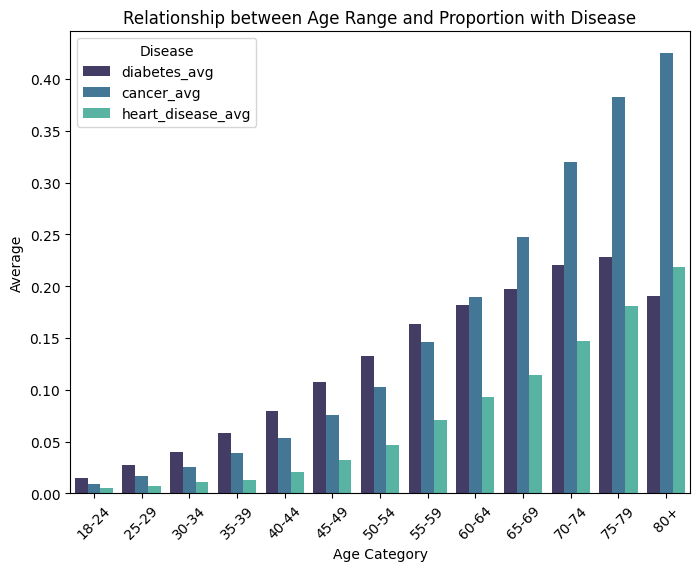

In [ ]:
# modifies the data graph to be more plottable
query = '''
SELECT Age_Category, 'diabetes_avg' AS disease, diabetes_avg AS average FROM age_relationship
UNION ALL
SELECT Age_Category, 'cancer_avg' AS disease, cancer_avg AS average FROM age_relationship
UNION ALL
SELECT Age_Category, 'heart_disease_avg' AS disease, heart_disease_avg AS average FROM age_relationship;
'''

age_relationship_fixed = ps.sqldf(query, locals())
age_relationship_fixed.head(10)

# Create a bar graph of the age to sickness avg using Seaborn
plt.figure(figsize=(8, 6))

sns.barplot(
    data=age_relationship_fixed,
    x='Age_Category',
    y='average',
    hue='disease',
    palette='mako'
)

plt.xlabel('Age Category')
plt.ylabel('Average')
plt.title('Relationship between Age Range and Proportion with Disease')
plt.legend(title='Disease')

# rotates the label for legibility
plt.xticks(rotation=45)

# graph the plot
plt.show()

Looking at the graph, for all diseases there was an intuitive positive correlation between increased age and prevalence. We concluded that all three diseases were good indicators of health to include into our model.

Interestingly, diabetes has a drop off in the 80+ age group. Though this confused us at first, this might be explained by the average life expectancy of people with diabetes is 71-75 (i.e. those who survived past that more likely didn’t have it).

###**5.1.2** Exploring Relationships Between BMI and Diseases

Next, we wanted to test if BMI was a good indicator to include in our models. Given a lot of recent literature critquing the validity of BMI (since it doesn't take into account features like muscle mass), we wanted to see if it offered any value to our model. Since we had learned that the diseases were good measures of an individuals health level, we decided to compare BMI and those disease to see if any conclusion was to be found.

We first started by grouping together heart disease:

In [ ]:
# groups by diabetes and compares it with age
query = '''
SELECT
CASE
  WHEN BMI BETWEEN -1 AND 18.49 THEN 'Under Weight'
  WHEN BMI BETWEEN 18.5 AND 24.99 THEN 'Healthy'
  WHEN BMI BETWEEN 25 AND 29.99 THEN 'Over Weight'
  WHEN BMI BETWEEN 30 AND 1000 THEN 'Obese'
  ELSE 'Alien'
END AS BMI_standard, AVG(Heart_Disease_Num) as heart_disease_avg
FROM cvd_df
GROUP BY BMI_standard
'''

heart_disease_and_BMI = ps.sqldf(query, locals())
heart_disease_and_BMI.head()

,BMI_standard,heart_disease_avg
0,Healthy,0.061969
1,Obese,0.096052
2,Over Weight,0.082014
3,Under Weight,0.074939


We continued by grouping together cancer:

In [ ]:
# groups by cancer and compares it with age
query = '''
SELECT
CASE
  WHEN BMI BETWEEN -1 AND 18.49 THEN 'Under Weight'
  WHEN BMI BETWEEN 18.5 AND 24.99 THEN 'Healthy'
  WHEN BMI BETWEEN 25 AND 29.99 THEN 'Over Weight'
  WHEN BMI BETWEEN 30 AND 1000 THEN 'Obese'
  ELSE 'Alien'
END AS BMI_standard, AVG(Cancer_Num) as cancer_avg
FROM cvd_df
GROUP BY BMI_standard
'''

cancer_and_BMI = ps.sqldf(query, locals())
cancer_and_BMI.head()

,BMI_standard,cancer_avg
0,Healthy,0.173851
1,Obese,0.160507
2,Over Weight,0.179286
3,Under Weight,0.174124


Lastly, we grouped together diabetes data:

In [ ]:
# groups by diabetes and compares it with age
query = '''
SELECT
CASE
  WHEN BMI BETWEEN -1 AND 18.49 THEN 'Under Weight'
  WHEN BMI BETWEEN 18.5 AND 24.99 THEN 'Healthy'
  WHEN BMI BETWEEN 25 AND 29.99 THEN 'Over Weight'
  WHEN BMI BETWEEN 30 AND 1000 THEN 'Obese'
  ELSE 'Alien'
END AS BMI_standard, AVG(Diabetes_Num) as diabetes_avg
FROM cvd_df
GROUP BY BMI_standard
'''

diabetes_and_BMI = ps.sqldf(query, locals())
diabetes_and_BMI.head()

,BMI_standard,diabetes_avg
0,Healthy,0.066882
1,Obese,0.222520
2,Over Weight,0.120606
3,Under Weight,0.055323


With all the data collected, we joined it together into one dataframe that has all the data in it for ease of comarison.

In [ ]:
# joins the age based data into one df
query = '''
SELECT d.BMI_standard, d.diabetes_avg, c.cancer_avg, hd.heart_disease_avg
FROM diabetes_and_BMI d
INNER JOIN cancer_and_BMI c
  ON d.BMI_standard = c.BMI_standard
INNER JOIN heart_disease_and_BMI hd
  ON d.BMI_standard = hd.BMI_standard
'''

BMI_relationship = ps.sqldf(query, locals())
BMI_relationship.head(10)

,BMI_standard,diabetes_avg,cancer_avg,heart_disease_avg
0,Healthy,0.066882,0.173851,0.061969
1,Obese,0.222520,0.160507,0.096052
2,Over Weight,0.120606,0.179286,0.082014
3,Under Weight,0.055323,0.174124,0.074939


Finally, we used the combined data to graph the plot. Given the demands of SNS multi category bar graphs, we reformatted the data first to better produce the final bar graph.

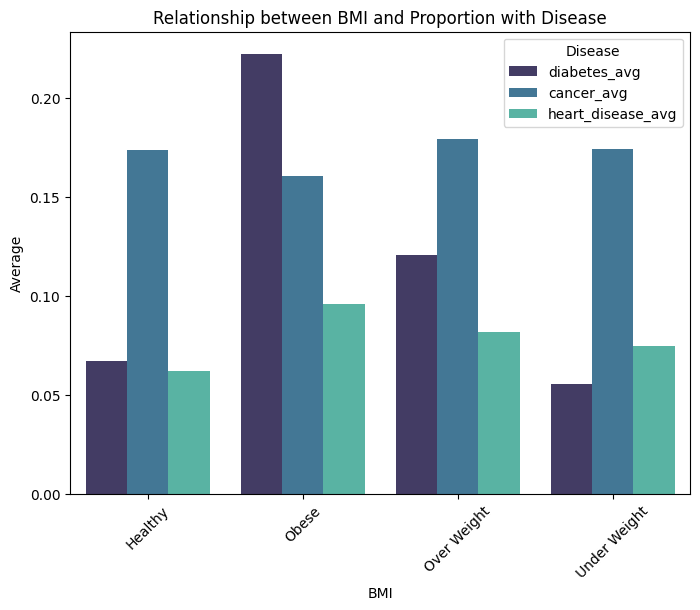

In [ ]:
# modifies the data graph to be more plottable
query = '''
SELECT BMI_standard, 'diabetes_avg' AS disease, diabetes_avg AS average FROM BMI_relationship
UNION ALL
SELECT BMI_standard, 'cancer_avg' AS disease, cancer_avg AS average FROM BMI_relationship
UNION ALL
SELECT BMI_standard, 'heart_disease_avg' AS disease, heart_disease_avg AS average FROM BMI_relationship;
'''

BMI_relationship_fixed = ps.sqldf(query, locals())

# Create a bar graph of the age to sickness avg using Seaborn
plt.figure(figsize=(8, 6))

sns.barplot(
    data=BMI_relationship_fixed,
    x='BMI_standard',
    y='average',
    hue='disease',
    palette='mako'
)

plt.xlabel('BMI')
plt.ylabel('Average')
plt.title('Relationship between BMI and Proportion with Disease')
plt.legend(title='Disease')

# rotates the label for legibility
plt.xticks(rotation=45)

# graph the plot
plt.show()

Looking at the data, there was the expected positive correlation between BMI and diabetes. At the same time, however, both cancer and heart disease did not have a strong or even any correlation with BMI. Given that we knew diseases like cancer certainly negatively impact health, this finding solidified our suspicion that BMI might not be a good measure of health


###**5.1.3** Exploring Relationships Between Disease Combinations and General Health


Since we have established that the diseases taken together offer a reasonable (albeit slightly limited) picture of health, we wanted to see if our initial observation regarding the limitations of self assessment played out over large numbers.

The first step in the process was to group by the the three diseases that we cared about. Afterwards, we used aggregate function to create an additional column that assigned a lable to the individual depending on the different sicknesses they had.

In [ ]:
# function to add classifying label
def add_label(row):
    diseases_present = (row[['Heart_Disease_Num', 'Diabetes_Num', 'Cancer_Num']] != 0).sum()

    if diseases_present == 3:
        return 'All Three'
    elif diseases_present == 2:
        if (row[['Heart_Disease_Num', 'Diabetes_Num']] != 0).sum() == 2:
            return 'Heart Disease and Diabetes'
        elif (row[['Heart_Disease_Num', 'Cancer_Num']] != 0).sum() == 2:
            return 'Heart Disease and Cancer'
        elif (row[['Cancer_Num', 'Diabetes_Num']] != 0).sum() == 2:
            return 'Cancer and Diabetes'
        else:
            return "error"
    elif diseases_present == 1:
        if (row[['Heart_Disease_Num']] != 0).sum() == 1:
            return 'Heart Disease Only'
        elif (row[['Cancer_Num']] != 0).sum() == 1:
            return 'Cancer Only'
        elif (row[['Diabetes_Num']] != 0).sum() == 1:
            return 'Diabetes Only'
        else:
            return "error"
    else:
        return 'No Illnesses'

# groups by the diseases that a person has
cvd_to_health_df = cvd_df.groupby(['Heart_Disease_Num', 'Diabetes_Num', 'Cancer_Num'])['General_Health_Num'].mean().reset_index()

# adds label to the different arrangements of diseases
cvd_to_health_df['Label'] = cvd_to_health_df.apply(add_label, axis=1);

# sorts by length of label
cvd_to_health_df = cvd_to_health_df.sort_values(by='General_Health_Num')

cvd_to_health_df.head(10)

,Heart_Disease_Num,Diabetes_Num,Cancer_Num,General_Health_Num,Label
0,0,0,0,2.268873,No Illnesses
1,0,0,1,2.545038,Cancer Only
2,0,1,0,3.007106,Diabetes Only
4,1,0,0,3.074567,Heart Disease Only
3,0,1,1,3.151283,Cancer and Diabetes
5,1,0,1,3.220524,Heart Disease and Cancer
6,1,1,0,3.559278,Heart Disease and Diabetes
7,1,1,1,3.632608,All Three


With the categories assigned, we graphed the plot showing how different people with differnt diseases rated their own health.

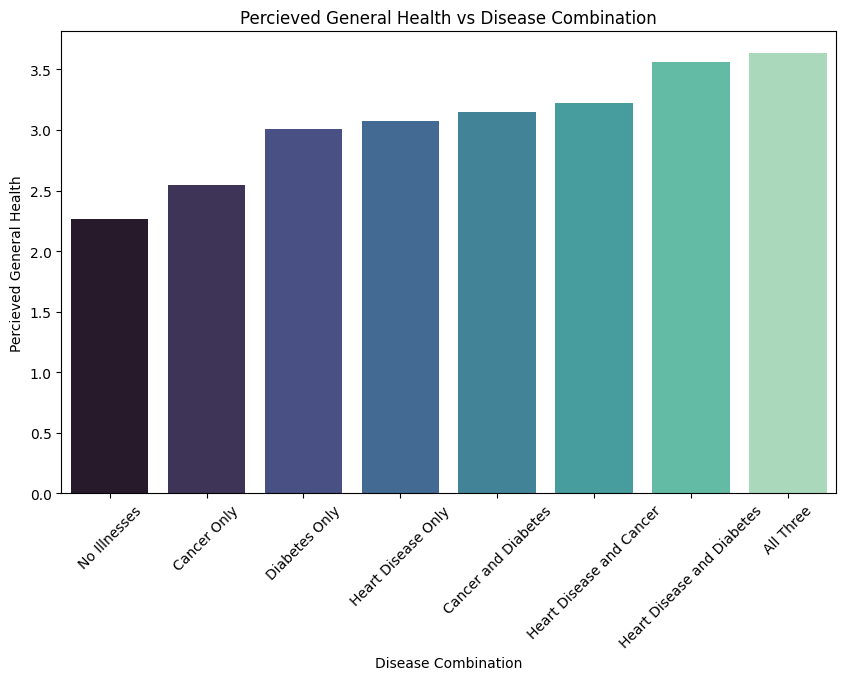

In [ ]:
# Create a bar plot graphing the disease combination with health
plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='General_Health_Num', data=cvd_to_health_df, palette="mako")

# Add labels and title
plt.xlabel('Disease Combination')
plt.ylabel('Percieved General Health')
plt.title('Percieved General Health vs Disease Combination')

# rotates the label for legibility
plt.xticks(rotation=45)

# Show the plot
plt.show()

Despite our initial observation between the discrepancy between self reported health actual observed conditions, this exploration suggested otherwise. In fact, there was a strong correlation between how poor one rated their health with the presence of the diseases we investigated. Given the overall correlation while also the individual cases were there is a clear mismatch, this result showed us that the main benefit of our approach is the reliability of our assessment rather than general trend.


## **5.2** Pairwise correlation of columns

To explore the correlation between variables in our dataset, we created heatmaps with Seaborn. First, we take a look at the correlations between all variables in the dataset.

<ipython-input-55-9bc197c5ce94>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = cvd_df.corr()


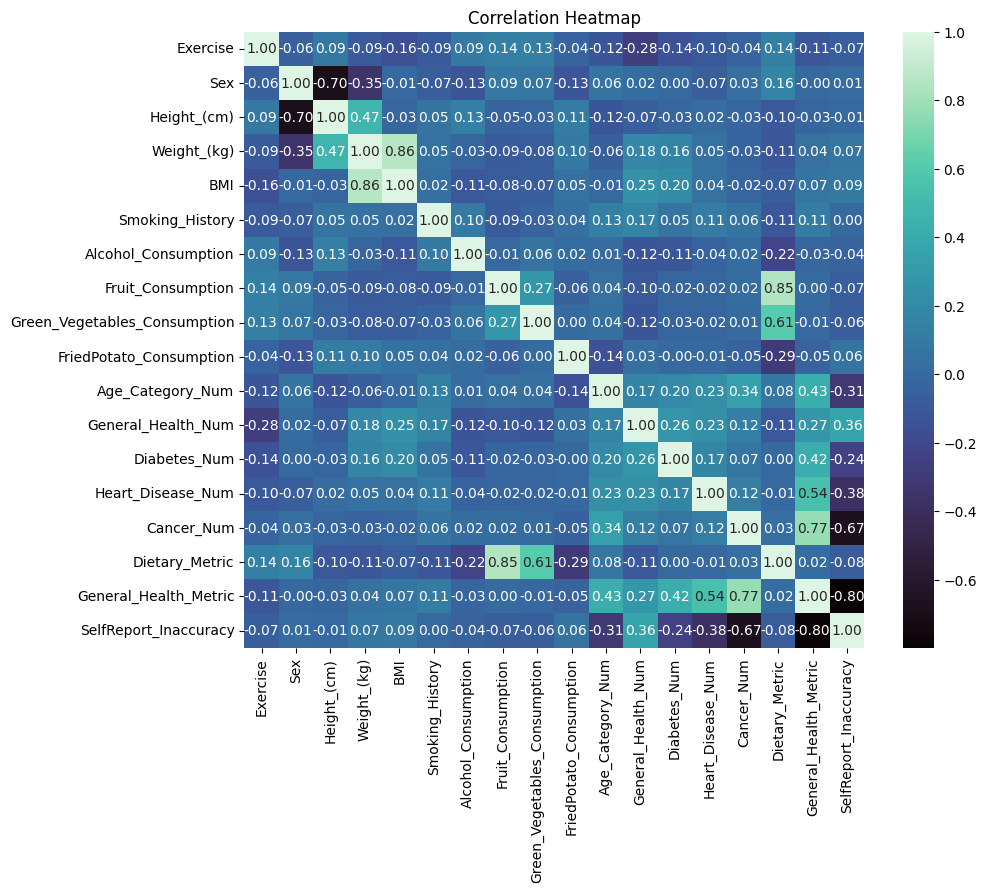

In [ ]:
# Heatmap demonstrating all pairwise correlations

from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = cvd_df.corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='mako', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

Some non-trivial correlations noticed were correlations between dietary habits, correlations between BMI/general health/diabetes, and correlations between age and disease. We focused on just these columns in the following heatmaps.

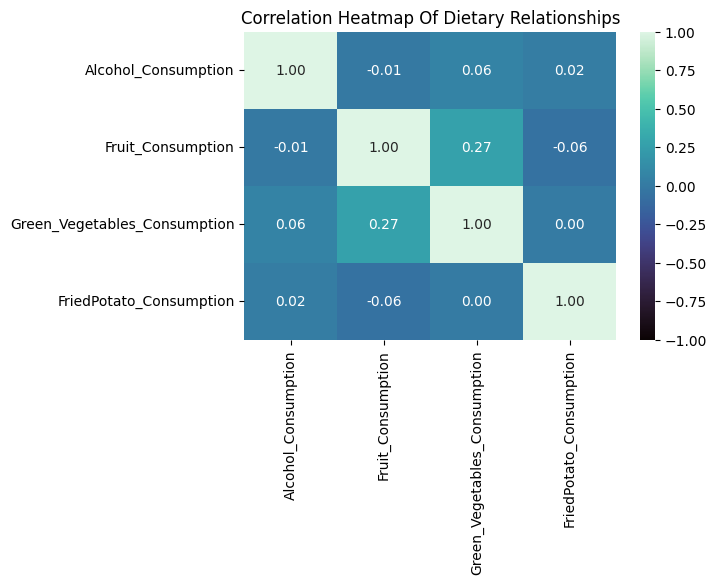

In [ ]:
# Heatmap demonstrating pairwise correlations between consumption of food/alcohol

import seaborn as sns
import matplotlib.pyplot as plt

cvd_df_subset = cvd_df[['Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']]

correlation_matrix = cvd_df_subset.corr()

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='mako', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Of Dietary Relationships')
plt.show()

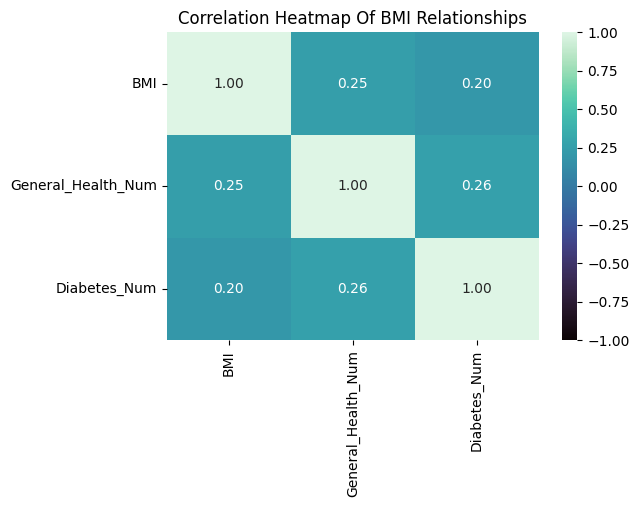

In [ ]:
# Heatmap demonstrating pairwise correlations between BMI, self reported health, and diabetes

import seaborn as sns
import matplotlib.pyplot as plt

cvd_df_subset = cvd_df[['BMI', 'General_Health_Num', 'Diabetes_Num']]

correlation_matrix = cvd_df_subset.corr()

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='mako', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Of BMI Relationships')
plt.show()

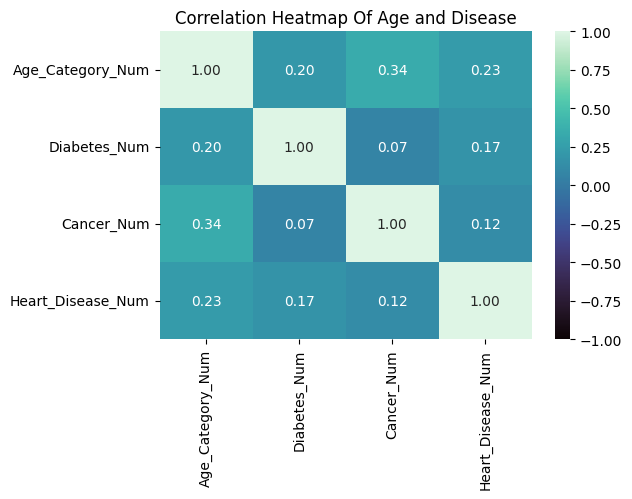

In [ ]:
# Heatmap demonstrating pairwise correlations between consumption of age and diseases.

import seaborn as sns
import matplotlib.pyplot as plt

cvd_df_subset = cvd_df[['Age_Category_Num', 'Diabetes_Num', 'Cancer_Num', 'Heart_Disease_Num']]

correlation_matrix = cvd_df_subset.corr()

plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='mako', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap Of Age and Disease')
plt.show()

While these relationships were not alarmingly strong, it is fair to notice that higher BMI correlates to diabetes and worse health, and older people are more likely to have disease. In addition, the last heatmap may suggest some sort of correlations across diseases (having one could be associated with more likelihood of having another).

## **5.3** Initial Models with Self-Reportable Metrics

We noticed that the dataset we focused on was commonly used to predict certain diseases. Thus, in this exploratory section, we decided to compare the feasibility of predicting diseases such as `Heart_Disease`, `Diabetes`, and `Cancer` (based on the self-reportable data found in the CVD dataset) to predicting the self-reported `General_Health` score. The first three mentioned models served as baseline models to compare how well each person's subjective `General_Health` report lined up with their objective data.

### 5.3.1 Preprocessing

First, we extract features and train/test splits for all 4 of the models we wish to test.





In [ ]:
# Get features
features = cvd_df[['Exercise', 'Sex',
               'Age_Category_Num', 'Height_(cm)', 'Weight_(kg)', 'BMI',
               'Alcohol_Consumption', 'Smoking_History',
               'Fruit_Consumption', 'Green_Vegetables_Consumption',
               'FriedPotato_Consumption']]

# Train test split for each indication
seed = 0
X_train_gh, X_test_gh, y_train_gh, y_test_gh = train_test_split(features, cvd_df['General_Health'], random_state=seed, test_size=0.2)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(features, cvd_df['Cancer'], random_state=seed, test_size=0.2)
X_train_hd, X_test_hd, y_train_hd, y_test_hd = train_test_split(features, cvd_df['Heart_Disease'], random_state=seed, test_size=0.2)
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(features, cvd_df['Diabetes'], random_state=seed, test_size=0.2)

print(y_train_gh.value_counts())
print(y_train_c.value_counts())
print(y_train_hd.value_counts())
print(y_train_db.value_counts())

Very Good    88268
Good         76268
Excellent    44944
Fair         28602
Poor          9001
Name: General_Health, dtype: int64
No     204977
Yes     42106
Name: Cancer, dtype: int64
No     227100
Yes     19983
Name: Heart_Disease, dtype: int64
No                                            207376
Yes                                            32084
No, pre-diabetes or borderline diabetes         5491
Yes, but female told only during pregnancy      2132
Name: Diabetes, dtype: int64


Next, in some cases we sample from the labels that are more prevalent to match the minimum label count. This is done because we noticed in the original dataset exploration that there were many class imbalances across the labels. We note it again in the previous code block as well. We chose to only perform this balancing to achieve a maximum ratio of 3:1 between any two labels in the dataset (i.e. Very Good is downsampled to at most 27003 samples). This is strike a balance between a larger dataset size and well-balanced classes.

In [ ]:
# Function to resample each of the training sets:
def downsample_train_set(Xtrain, ytrain):
    # Combine Xtrain and ytrain into a single DataFrame
    df = pd.concat([pd.DataFrame(Xtrain), pd.Series(ytrain, name='target')], axis=1)

    valcounts = df['target'].value_counts()
    minval = 3 * min(valcounts)

    for key in valcounts.index:
        if valcounts[key] > minval:
            # Downsampling logic goes here
            # For example, you can use pandas' sample method to downsample
            downsampled_rows = df[df['target'] == key].sample(n=minval, random_state=42)

            # Drop the original rows corresponding to the key
            df = df.drop(df[df['target'] == key].index)

            # Append the downsampled rows
            df = pd.concat([df, downsampled_rows], ignore_index=True)

    # Split the DataFrame back into Xtrain and ytrain
    Xtrain = df.drop('target', axis=1)
    ytrain = df['target']

    return Xtrain, ytrain

X_train_c, y_train_c = downsample_train_set(X_train_c, y_train_c)
X_train_hd, y_train_hd = downsample_train_set(X_train_hd, y_train_hd)
X_train_db, y_train_db = downsample_train_set(X_train_db, y_train_db)
X_train_gh, y_train_gh = downsample_train_set(X_train_gh, y_train_gh)

print(y_train_gh.value_counts())
print(y_train_c.value_counts())
print(y_train_hd.value_counts())
print(y_train_db.value_counts())

Very Good    27003
Good         27003
Excellent    27003
Fair         27003
Poor          9001
Name: target, dtype: int64
No     126318
Yes     42106
Name: target, dtype: int64
No     59949
Yes    19983
Name: target, dtype: int64
No                                            6396
Yes                                           6396
No, pre-diabetes or borderline diabetes       5491
Yes, but female told only during pregnancy    2132
Name: target, dtype: int64



Then, we scale all of the data.

In [ ]:
# Scale data for all sets
scaler_gh = StandardScaler()
X_train_gh = scaler_gh.fit_transform(X_train_gh)
X_test_gh = scaler_gh.transform(X_test_gh)

scaler_c = StandardScaler()
X_train_c = scaler_c.fit_transform(X_train_c)
X_test_c = scaler_c.transform(X_test_c)

scaler_hd = StandardScaler()
X_train_hd = scaler_hd.fit_transform(X_train_hd)
X_test_hd = scaler_hd.transform(X_test_hd)

scaler_db= StandardScaler()
X_train_db = scaler_db.fit_transform(X_train_db)
X_test_db = scaler_db.transform(X_test_db)

### 5.3.2 Training + Analysis

Now, as a simple categorical model we use Random Forest to see how well each of these targets can be predicted from just the self-reportable data. We chose RF over other models like Logistic Regression because it is well suited for categorical data. Our primary metric in this case is accuracy, as we are looking at categorical data, not continuous data. We also plot confusion matrices, and consider precision, recall and F1 scores to make our analysis more robust.

In [ ]:
rf_c = RandomForestClassifier(n_estimators=50, max_depth=30, random_state=42)
rf_c.fit(X_train_c, y_train_c)

y_pred = rf_c.predict(X_test_c)
conf_mat = confusion_matrix(y_test_c, y_pred)
print('Confusion Matrix\n', conf_mat)

class_rpt = classification_report(y_test_c, y_pred)
print(class_rpt)

Confusion Matrix
 [[46350  4634]
 [ 7926  2861]]
              precision    recall  f1-score   support

          No       0.85      0.91      0.88     50984
         Yes       0.38      0.27      0.31     10787

    accuracy                           0.80     61771
   macro avg       0.62      0.59      0.60     61771
weighted avg       0.77      0.80      0.78     61771



In [ ]:
rf_hd = RandomForestClassifier(n_estimators=50, max_depth=30, random_state=42)
rf_hd.fit(X_train_hd, y_train_hd)

y_pred = rf_hd.predict(X_test_hd)
conf_mat = confusion_matrix(y_test_hd, y_pred)
print('Confusion Matrix\n', conf_mat)

class_rpt = classification_report(y_test_hd, y_pred)
print(class_rpt)

Confusion Matrix
 [[51223  5560]
 [ 3376  1612]]
              precision    recall  f1-score   support

          No       0.94      0.90      0.92     56783
         Yes       0.22      0.32      0.27      4988

    accuracy                           0.86     61771
   macro avg       0.58      0.61      0.59     61771
weighted avg       0.88      0.86      0.87     61771



In [ ]:
rf_db = RandomForestClassifier(n_estimators=50, max_depth=30, random_state=42)
rf_db.fit(X_train_db, y_train_db)

y_pred = rf_db.predict(X_test_db)
conf_mat = confusion_matrix(y_test_db, y_pred)
print('Confusion Matrix\n', conf_mat)

class_rpt = classification_report(y_test_db, y_pred)
print(class_rpt)

Confusion Matrix
 [[26998  8680 12068  4019]
 [  364   345   624    72]
 [ 1631  1904  4346   206]
 [  200    81    75   158]]
                                            precision    recall  f1-score   support

                                        No       0.92      0.52      0.67     51765
   No, pre-diabetes or borderline diabetes       0.03      0.25      0.06      1405
                                       Yes       0.25      0.54      0.34      8087
Yes, but female told only during pregnancy       0.04      0.31      0.06       514

                                  accuracy                           0.52     61771
                                 macro avg       0.31      0.40      0.28     61771
                              weighted avg       0.81      0.52      0.61     61771



In [ ]:
rf_gh = RandomForestClassifier(n_estimators=50, max_depth=30, random_state=42)
rf_gh.fit(X_train_gh, y_train_gh)

y_pred = rf_gh.predict(X_test_gh)
conf_mat = confusion_matrix(y_test_gh, y_pred)
print('Confusion Matrix\n', conf_mat)

class_rpt = classification_report(y_test_gh, y_pred)
print(class_rpt)

Confusion Matrix
 [[5302 1403 1642  102 2561]
 [ 930 3226 1692  378  982]
 [4054 5910 4780  456 3896]
 [ 235 1279  395  216  205]
 [7457 4118 4647  299 5606]]
              precision    recall  f1-score   support

   Excellent       0.29      0.48      0.37     11010
        Fair       0.20      0.45      0.28      7208
        Good       0.36      0.25      0.30     19096
        Poor       0.15      0.09      0.11      2330
   Very Good       0.42      0.25      0.32     22127

    accuracy                           0.31     61771
   macro avg       0.29      0.31      0.27     61771
weighted avg       0.35      0.31      0.31     61771



From this explorative modeling, we concluded that it was clearly more difficult to predict individuals' self-assessments from self-reportable data, while it was relatively effective to predict their objective disease states. This confirmed a lot of the suspicions we had developed over the course of the project thus far and encouraged us to continue on with investigating our engineered `SelfReport_Inaccuracy` column (section 5.5). We also took into account that `General_Health` had more labels by comparing it to `Diabetes` prediction above, which had a similar number (5 v. 4) but still superior accuracy. However, it was notable that the per-label precision was more inconcsistent in the `Diabetes` prediction, likely due to the label distribution in the test set.

## **5.5**: Investigating Demographic Differences in Self-Assessment Inconsistency

Due to the noticed difficulty of predicting individual self-assessments of health, we decided to further investigate how demographic differences may contribute to the inconsistency of these self-assessments. In particular, we looked into sex, age, and BMI. Note that in the following graphs, a higher positive value for Average Inaccuracy means a certain population tended to predict that they were healthier than they really were.

### 5.5.1 Sex-based differences

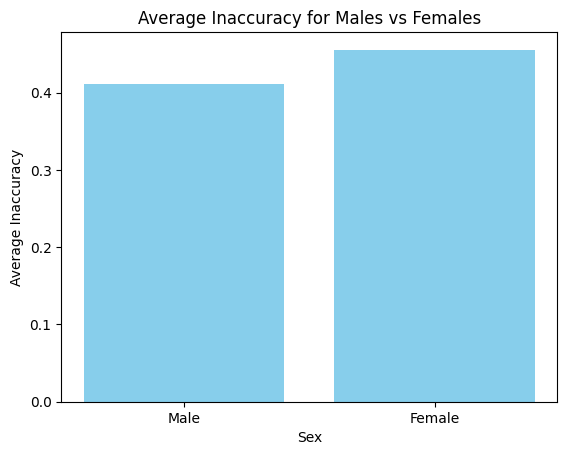

In [ ]:
# Bar graph displaying difference in self-report inaccuracy by sex

avg_inaccuracy = cvd_df.groupby('Sex')['SelfReport_Inaccuracy'].mean()

plt.bar(['Male', 'Female'], avg_inaccuracy, color='skyblue')
plt.xlabel('Sex')
plt.ylabel('Average Inaccuracy')
plt.title('Average Inaccuracy for Males vs Females')
plt.show()


This difference is miniscule, and suggests low differences between men and women in reporting their health.

### 5.5.2 Age-based differences

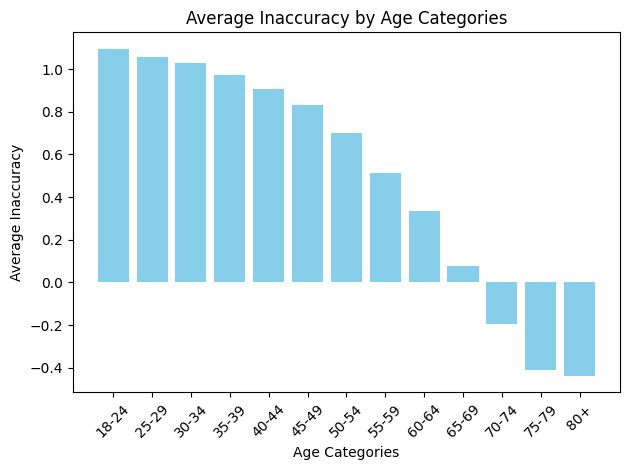

In [ ]:
avg_inaccuracy_age = cvd_df.groupby('Age_Category')['SelfReport_Inaccuracy'].mean()

age_categories = list(avg_inaccuracy_age.index)
avg_inaccuracy_values = list(avg_inaccuracy_age.values)

plt.bar(age_categories, avg_inaccuracy_values, color='skyblue')
plt.xlabel('Age Categories')
plt.ylabel('Average Inaccuracy')
plt.title('Average Inaccuracy by Age Categories')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The strong trend in this particular graph shows that younger people tend to think they are healthier than they really are, and older people tend to think they are unhealthier than they really are.

### 5.5.3 Height/Weight/BMI-based differences

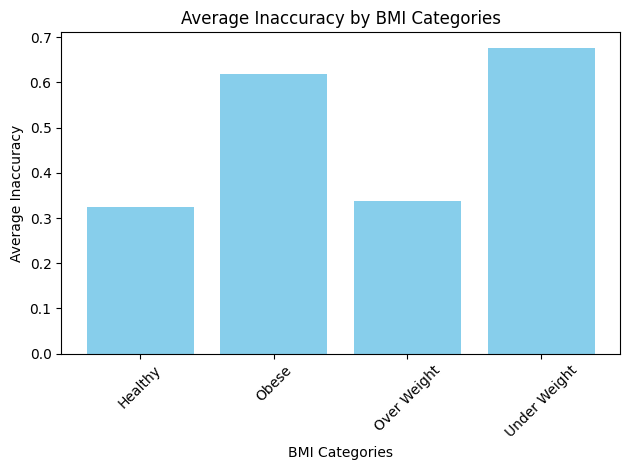

In [ ]:
# Function to categorize BMI values
def categorize_bmi(bmi):
    if -1 <= bmi <= 18.49:
        return 'Under Weight'
    elif 18.5 <= bmi <= 24.99:
        return 'Healthy'
    elif 25 <= bmi <= 29.99:
        return 'Over Weight'
    elif 30 <= bmi <= 1000:
        return 'Obese'
    else:
        return 'None'

cvd_df['BMI_category'] = cvd_df['BMI'].apply(categorize_bmi)

avg_inaccuracy_BMI = cvd_df.groupby('BMI_category')['SelfReport_Inaccuracy'].mean()

age_categories = list(avg_inaccuracy_BMI.index)
avg_inaccuracy_values = list(avg_inaccuracy_BMI.values)

plt.bar(age_categories, avg_inaccuracy_values, color='skyblue')
plt.xlabel('BMI Categories')
plt.ylabel('Average Inaccuracy')
plt.title('Average Inaccuracy by BMI Categories')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This suggests that people on the extremes of the BMI ranges (obese, underweight) tended to think that they are healthier than they are compared to healthy people (and also overweight people).

# **Part 6**: Predicting General Health Self-Score Inaccuracy

After noticing over and over again the vast inaccuracies in these individuals' ability to provide `General_Health` assessments that correspond to their objective dietary and disease data, we aimed to create a model that could predict the level of inaccuracy of each individual's self-assessment. This section creates a baseline model for this problem step-by-step.

## **6.1** Preprocessing

First, we will further preprocess the data to suit our needs.

### 6.1.1 Extract + scale features from dataframe

We scale prior to performing PCA because PCA is scale invariant and will give more reliable analyses without the presence of huge outliers in the data.

In [ ]:
# Get the feature data just as before
features = cvd_df[['Exercise', 'Sex',
               'Age_Category_Num', 'Height_(cm)', 'Weight_(kg)', 'BMI',
               'Alcohol_Consumption', 'Smoking_History',
               'Fruit_Consumption', 'Green_Vegetables_Consumption',
               'FriedPotato_Consumption']]

# Train test split for each indication
seed = 0
X_train, X_test, y_train, y_test = train_test_split(features, cvd_df['SelfReport_Inaccuracy'], random_state=seed, test_size=0.2)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 6.1.2 PCA

Here, we graphically identify the ideal number of components to use for PCA.

In [ ]:
# PCA
pca = PCA()
X_train_initialfit = pca.fit(X_train_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)
cum_evr

array([0.21160564, 0.36163269, 0.48159139, 0.59047525, 0.68245457,
       0.76598847, 0.83933356, 0.90626889, 0.97067865, 0.99933503,
       1.        ])

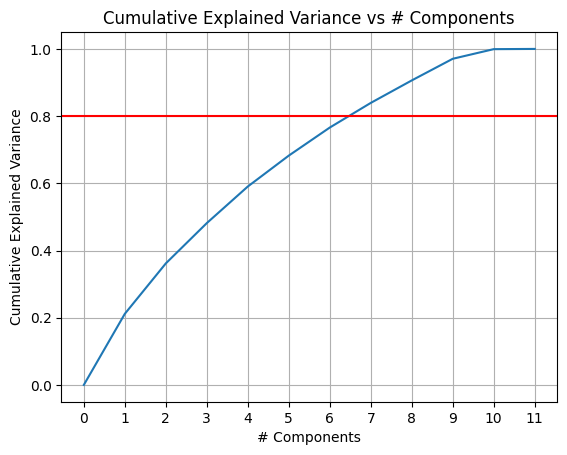

In [ ]:
# Plot the explained variance vs num of components
cum_evr = np.insert(cum_evr, 0, 0)
plt.plot(cum_evr)
plt.xlabel('# Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs # Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1))
plt.grid()
plt.show()

The plot above demonstrates the the ideal number of components is 7, as it is the lowest integer value to surpass the threshold of 80% explained variance. Thus we re-fit and transform our data according to this number.

In [ ]:
pca_final = PCA(n_components = 7)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

## **6.2** Baseline Modeling from Self-Reportable Data

To best fit the need for an easy method to determine the inaccuracy of self-reporting, it would be best to gain a metric from the other self-reported data. This is because it is easy-to-obtain but increasedly objective/straightforward. Thus, we first generate a baseline model from this data.

### 6.2.1 Linear Regression without PCA

In [ ]:
# Fit model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict on transformed test data using the linear regression model
y_pred = lr.predict(X_test_scaled)
lr_score_test = lr.score(X_test_scaled, y_test)
lr_score_train = lr.score(X_train_scaled, y_train)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print('Test R^2 value: ' + str(lr_score_test))
print('Train R^2 value: ' + str(lr_score_train))
print('MSE: ' + str(mse))

Test R^2 value: 0.11932243005765153
Train R^2 value: 0.11536307089129116
MSE: 2.4120566143278217


The R-squared values for the training set and test set are similar, implying that there is no overfitting occuring here. Instead, the low R-squared likely comes from Linear Regression's tendency to underfit to data. This implies there are some non-linear relationships that we have to adapt our model to gather. We will address this in Part 7.

### 6.2.2 Linear Regression after PCA

In [ ]:
# Linreg training + predicting
lr = LinearRegression()
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

# Getting metrics for regression (R2 and MSE)
lr_score_test = lr.score(X_test_pca, y_test)
lr_score_train = lr.score(X_train_pca, y_train)
mse = mean_squared_error(y_test, y_pred)

print('Test R^2: ' + str(lr_score_test))
print('Train R^2: ' + str(lr_score_train))
print('MSE: ' + str(mse))

Test R^2: 0.07920635743570792
Train R^2: 0.0776125409598325
MSE: 2.521929105249725


Using PCA we get very similar results, if not worse, results. Thus, we will ultimately only use the non-transformed set in the future (without dimensionality reduction). Note that the dimensionality reduction is not by very much in the first place.

## **6.3** Modeling from Disease State

In a case where a person's has knowledge of or access to some or all medical records, this would also potentially provide additional information to the regressive model. As such this predictive paradigm was also baselined here.

In [ ]:
# Get the feature data just as before
features_disease = cvd_df[['Exercise', 'Sex',
               'Age_Category_Num', 'Height_(cm)', 'Weight_(kg)', 'BMI',
               'Alcohol_Consumption', 'Smoking_History',
               'Fruit_Consumption', 'Green_Vegetables_Consumption',
               'FriedPotato_Consumption',
               'Cancer_Num', 'Diabetes_Num','Heart_Disease_Num']]

# Train test split for each indication
seed = 0
X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(features_disease, cvd_df['SelfReport_Inaccuracy'], random_state=seed, test_size=0.2)

# Scaling
scaler = StandardScaler()
X_train_dis_scaled = scaler.fit_transform(X_train_dis)
X_test_dis_scaled = scaler.transform(X_test_dis)

# PCA
pca = PCA()
X_train_initialfit = pca.fit(X_train_dis_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = np.cumsum(explained_variance_ratios)
cum_evr

array([0.16848776, 0.30072057, 0.40973168, 0.50336586, 0.57649905,
       0.64828018, 0.7126415 , 0.77088892, 0.82796246, 0.88423461,
       0.93483356, 0.97710994, 0.9994777 , 1.        ])

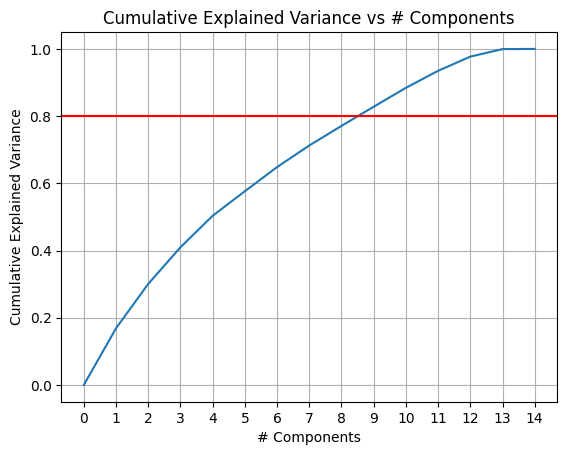

In [ ]:
# Plot the explained variance vs num of components
cum_evr = np.insert(cum_evr, 0, 0)
plt.plot(cum_evr)
plt.xlabel('# Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs # Components')
plt.axhline(y = 0.8, color = 'r', linestyle = '-')
plt.xticks(np.arange(0, len(explained_variance_ratios)+1))
plt.grid()
plt.show()

In this case, the plot above demonstrates the the ideal number of components is 9, as it is the lowest integer value to surpass the threshold of 80% explained variance. Thus we re-fit and transform our data according to this number.

In [ ]:
pca_final = PCA(n_components = 9)
X_train_dis_pca = pca_final.fit_transform(X_train_dis_scaled)
X_test_dis_pca = pca_final.transform(X_test_dis_scaled)

We use Linear Regression again here (both with and without PCA for testing), just to isolate how adding additional feature complexity affects model performance.

In [ ]:
# Linreg model training + predicting
lr_dis = LinearRegression()
lr_dis.fit(X_train_dis_scaled, y_train_dis)
y_pred_dis = lr_dis.predict(X_test_dis_scaled)

# Getting metrics for regression (R2 and MSE)
lr_dis_score_test = lr_dis.score(X_test_dis_scaled, y_test_dis)
lr_dis_score_train = lr_dis.score(X_train_dis_scaled, y_train_dis)
mse_dis = mean_squared_error(y_test_dis, y_pred_dis)

print('(w/o PCA) Test R^2 value: ' + str(lr_dis_score_test))
print('(w/o PCA) Train R^2 value: ' + str(lr_dis_score_train))
print('(w/o PCA) MSE: ' + str(mse_dis))

(w/o PCA) Test R^2 value: 0.609296331451853
(w/o PCA) Train R^2 value: 0.6046834446972769
(w/o PCA) MSE: 1.070084444214237


In [ ]:
# Linreg model training + predicting
lr_dis = LinearRegression()
lr_dis.fit(X_train_dis_pca, y_train_dis)
y_pred_dis = lr_dis.predict(X_test_dis_pca)

# Getting metrics for regression (R2 and MSE)
lr_dis_score_test = lr_dis.score(X_test_dis_pca, y_test_dis)
lr_dis_score_train = lr_dis.score(X_train_dis_pca, y_train_dis)
mse_dis = mean_squared_error(y_test_dis, y_pred_dis)

print('(With PCA) Test R^2 value: ' + str(lr_dis_score_test))
print('(With PCA) Train R^2 value: ' + str(lr_dis_score_train))
print('(With PCA) MSE: ' + str(mse_dis))

(With PCA) Test R^2 value: 0.5247335227302888
(With PCA) Train R^2 value: 0.5158813406057496
(With PCA) MSE: 1.3016905269220544


Immediately, we see an improvement in the model's performance both with and without PCA, suggesting that it more or less likely for those with some or all of the diseases recorded in this dataset to have a self-reported health rating that differs from their objective health. Also, the dimensionality reduction again affects the results so we conclusively will continue on to Part 7 without using it.

# **Part 7:** Refining Our Model

In order to refine this model for self-assessment inaccuracy, we tried using several boosted and/or stacked regressors, as well as a neural network. After determining which of these models worked best for our application, we performed hyperparameter optimization to further improve the model.

## **7.1** Testing Additional Models

### 7.1.1 Gradient Boosting Regression (XGBRegressor)

To try and improve from the initial self-reportable data model without adding the more difficult-to-obtain features, we used a gradient-boosting regression model, XGBRegressor, and ensemble method that combines many models and therefore captures nonlinear and linear relationships at once.

In [ ]:
# XGBRegressor model training + fitting
xgb = XGBRegressor(eta=0.1, max_depth=6, seed=42)
xgb.fit(X_train_pca, y_train)
y_pred_train = xgb.predict(X_train_pca)
y_pred_test = xgb.predict(X_test_pca)

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_xgb = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse))

Train R^2 value: 0.14355582337832795
Test R^2 value: 0.12072037653417922
MSE: 2.521929105249725


We tried the same model, but incorporating disease again.

In [ ]:
# XGBRegressor model training + fitting
xgb = XGBRegressor(eta=0.1, max_depth=6, seed=42)
xgb.fit(X_train_dis_scaled, y_train)
y_pred_train = xgb.predict(X_train_dis_scaled)
y_pred_test = xgb.predict(X_test_dis_scaled)

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_xgb = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_xgb))

Train R^2 value: 0.7120645141149973
Test R^2 value: 0.7080877486623784
MSE: 0.7995081295057038


This ensemble method yielded decent improvement to both sets of our results but we first moved on to other options for model selection to gain breadth of search first. This was especially because the R^2 for the features without disease state was still relatively low. However, we come back to it later with hyperparameter optimization to see if it can be further improved.

### 7.1.2 Support Vector Regression

Next, we tried using an SVR, which prioritizes the more difficul-to-predict points by ignoring closer-to-correct samples in its cost function. However, due to its high O(n\_features * n\_samples^3) runtime, this quickly became infeasible for such a large dataset. Therefore, the code was commented and this model was abandoned for this use case.

In [ ]:
# # SVM model training + fitting
# svr = svm.SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
# svr.fit(X_train_pca, y_train)
# y_pred_train = svr.predict(X_train_pca)
# y_pred_test = svr.predict(X_test_pca)

# Getting metrics for regression (R2 and MSE)
# r2_train = r2_score(y_train, y_pred_train)
# r2_test = r2_score(y_test, y_pred_test)
# mse_svr = mean_squared_error(y_test, y_pred_test)

# print('Train R^2 value: ' + str(r2_train))
# print('Test R^2 value: ' + str(r2_test))
# print('MSE: ' + str(mse_svr))

### 7.1.3 Random Forest Regression

Due to the shortcomings of previous models, we attempted using another ensemble method, Random Forest Regression. Note that even though RFR is scale invariant, we plug in the scaled values for consistency.

In [ ]:
# RFR model training + fitting
rfr = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rfr.fit(X_train_scaled, y_train)
y_pred_train = rfr.predict(X_train_scaled)
y_pred_test = rfr.predict(X_test_scaled) # We input scaled variable here even though RFR is scale invariant, just for consistency

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_rfr = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_rfr))

Train R^2 value: 0.14089137787353756
Test R^2 value: 0.13326286814607757
MSE: 2.373875642033936


We repeated again with the included disease features.

In [ ]:
# RFR model training + fitting
rfr = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42)
rfr.fit(X_train_dis_scaled, y_train)
y_pred_train = rfr.predict(X_train_dis_scaled)
y_pred_test = rfr.predict(X_test_dis_scaled) # We input scaled variable here even though RFR is scale invariant, just for consistency

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_rfr = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_rfr))

Train R^2 value: 0.7026068228957038
Test R^2 value: 0.7019983620658825
MSE: 0.8161861348490655


Unfortunately, we still weren't able to get great results for this model using only self-reportable features either. With MSE of around 3.5 on all of the models we've used so far, this means the model gives virtually no certainty on how incorrect an individual could be on their self-report (unless we are able to ascertain their medical history as well). Fortunately, once that data is gained it is very easy to predict (within 1 point on the 1-5 scale) the inaccuracy of an individual.

### 7.1.4 Neural Network

For our final tested model, we designed a neural network. We hoped that this model would be best because neural networks tend to have the most complexity and can therefore capture the most detail in our dataset. The issue is still not overfitting, so this added complexity could help our prediction.

In [ ]:
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.1.0+cu118
cuda:0


Then, we defined a complex neural network with both linear and non-linear components. We chose to omit an activation layer (as is common in regression) and simply end on a linear layer because we aim to predict a linear target.

In [ ]:
# Architecture def
class NeuralNet(nn.Module):
    def __init__(self, size):
        super().__init__()

        self.l1 = nn.Linear(size, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.l4 = nn.Linear(32, 16)
        self.l5 = nn.Linear(16, 8)
        self.l6 = nn.Linear(8, 4)
        self.l7 = nn.Linear(4, 1)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x))
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        x = self.relu(self.l5(x))
        x = self.relu(self.l6(x))
        x = self.l7(x)

        return x

Next, we convert all of our data into tensors and instantiate our model.

In [ ]:
# Creating tensor from test and training data
X_train_tens = torch.from_numpy(X_train_scaled).float().to(device)
X_test_tens = torch.from_numpy(X_test_scaled).float().to(device)
y_train_tens = torch.from_numpy(y_train.values).float().to(device)
y_test_tens = torch.from_numpy(y_test.values).float().to(device)

# Define the model
neuralnet = NeuralNet(size = X_train_tens.shape[1])
neuralnet = neuralnet.to(device)
loss_criterion = nn.MSELoss()
optimizer = optim.Adam(neuralnet.parameters(), lr=0.001) #lr - learning step
epoch = 10
batch_size = 50
batch_start = torch.arange(0, len(X_train_tens), batch_size)

loss_LIST_log = []
r2train_LIST_log = []
r2test_LIST_log = []

Here, we train the model over the desired number of epochs and with the aforementioned batch size, keeping track of loss and R^2.

In [ ]:
# Train the neural network
for epoch in range(epoch):
    print("Epoch {}".format(epoch))
    running_loss = 0.0
    correct = 0
    total = 0
    for curr in batch_start:
        inputs = X_train_tens[curr: curr + batch_size].to(device)
        labels = y_train_tens[curr: curr + batch_size].view(-1, 1).to(device)

        optimizer.zero_grad()

        outputs = neuralnet(inputs).to(device)

        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Compute average loss for the epoch
    average_loss = running_loss / len(batch_start)

    y_test_pred = neuralnet(X_test_tens).detach().cpu().numpy()
    y_train_pred = neuralnet(X_train_tens).detach().cpu().numpy()

    r2_train = float(r2_score(y_train_pred, y_train_tens.cpu()))
    r2train_LIST_log.append(r2_train)

    r2_test = float(r2_score(y_test_pred, y_test_tens.cpu()))
    r2test_LIST_log.append(r2_test)

    mse = mean_squared_error(y_test_pred, y_test_tens.cpu())
    mse = float(mse)
    loss_LIST_log.append(mse)

    # print statistics
    print("The training R^2 for Epoch {} is: {}.".format(epoch, r2_train))
    print("The testing R^2 for Epoch {} is: {}.".format(epoch, r2_test))
    print("The loss (MSE) for Epoch {} is: {}.".format(epoch, mse))
    print("Average loss for Epoch {} is: {}.".format(epoch, average_loss))


Epoch 0
The training R^2 for Epoch 0 is: -5.706415939427639.
The testing R^2 for Epoch 0 is: -5.803654866782992.
The loss (MSE) for Epoch 0 is: 2.3809452056884766.
Average loss for Epoch 0 is: 2.3742072314011913.
Epoch 1
The training R^2 for Epoch 1 is: -5.664989448586253.
The testing R^2 for Epoch 1 is: -5.761444818598673.
The loss (MSE) for Epoch 1 is: 2.3764426708221436.
Average loss for Epoch 1 is: 2.3557401803981337.
Epoch 2
The training R^2 for Epoch 2 is: -5.663374221687632.
The testing R^2 for Epoch 2 is: -5.76333681512453.
The loss (MSE) for Epoch 2 is: 2.37593674659729.
Average loss for Epoch 2 is: 2.3531263151399426.
Epoch 3
The training R^2 for Epoch 3 is: -5.753818870923668.
The testing R^2 for Epoch 3 is: -5.854753952436284.
The loss (MSE) for Epoch 3 is: 2.374140501022339.
Average loss for Epoch 3 is: 2.3510586651700174.
Epoch 4
The training R^2 for Epoch 4 is: -5.646412528225697.
The testing R^2 for Epoch 4 is: -5.7464885215903925.
The loss (MSE) for Epoch 4 is: 2.37260

Based on this training, we concluded that the model was no better than any of our previous models, but were optimistic of our ability to improve it with either epoch increases or hyperparameter optimization. So, we proceeded to graph how R^2 and MSE changes as we progressed through the epochs.

Text(0, 0.5, 'MSE')

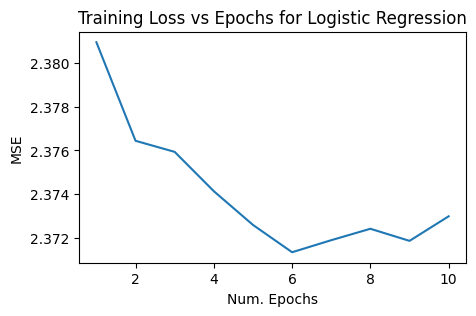

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(range(1,11), loss_LIST_log)
plt.title("Training Loss vs Epochs for Logistic Regression")
plt.xlabel("Num. Epochs")
plt.ylabel("MSE")

Text(0, 0.5, 'R^2 on Training Data')

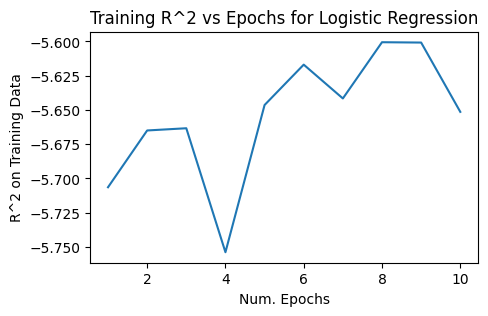

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(range(1,11), r2train_LIST_log)
plt.title("Training R^2 vs Epochs for Logistic Regression")
plt.xlabel("Num. Epochs")
plt.ylabel("R^2 on Training Data")

Text(0, 0.5, 'R^2 on Test Data')

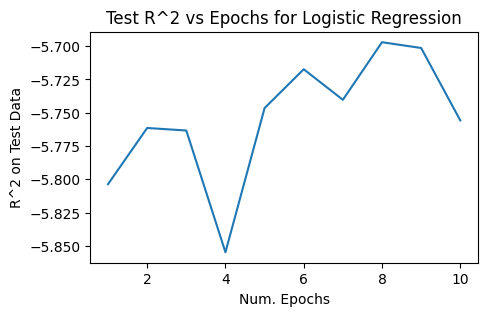

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(range(1,11), r2test_LIST_log)
plt.title("Test R^2 vs Epochs for Logistic Regression")
plt.xlabel("Num. Epochs")
plt.ylabel("R^2 on Test Data")

These training graphs demonstrate that, even with more epochs of training, the neural network architecture that we defined in unlikely to reach an R^2 or MSE similar to that of the ensemble regressors above. We tried several other hyperparameters in the hopes of increasing our success (i.e. learning rates of 1e-4, 0.1) but they did not help. Therefore, we did not continue to investigate neural networks in hyperparameter optimization.

## **7.2** Hyperparameter Optimization

Here, we revisit the more successful models from the previous section in an attempt to further improve regression via hyperparameter tuning. These most successful models were XGBRegressor and Random Forest Regressor.

### 7.2.1 Revisiting XGBRegressor

First, we use GridSearchCV to perform hyperparameter analysis on the XGBRegressor. In this case we used these two parameters because they were the primary ones altered in our initial exploration of the model. We chose a wide range of values to best pinpoint where we could optimize the model.

In [ ]:
# Define the paramgrid
paramgrid = {
    'eta': [1, 1e-1, 1e-2, 1e-3],
    'max_depth': [2, 5, 9, 15]
}

# Define XGB and grid search, then fit/train
xgb = XGBRegressor()
grid_search = GridSearchCV(xgb, param_grid = paramgrid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# best hyperparams
best_params = grid_search.best_params_
best_params

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'eta': 0.1, 'max_depth': 5}

Using those best parameters, we retrained the XGBRegressor models and compared its new results to our previous findings. First, we did so here in the model that uses only self-reportable data.

In [ ]:
# XGBRegressor model training + fitting
xgb = XGBRegressor(**best_params, seed=42)
xgb.fit(X_train_scaled, y_train)
y_pred_train = xgb.predict(X_train_scaled)
y_pred_test = xgb.predict(X_test_scaled)

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_xgb = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_xgb))

Train R^2 value: 0.14373692374722502
Test R^2 value: 0.13632110659212093
MSE: 2.3654995410365487


Unfortunately, we were still not able to yield a satisfactory regression with this hyperparameter optimization technique, as these R^2 and MSE values are still relatively high for the intended use case.

So, we also performed the grid search for our second model (our "backup"), which uses disease state as well. All parts of that optimization are performed in a single cell below.

In [ ]:
# Define the paramgrid
paramgrid = {
    'eta': [1, 1e-1, 1e-2, 1e-3],
    'max_depth': [2, 5, 9, 15]
}

# Define XGB and grid search, then fit/train
xgb = XGBRegressor()
grid_search = GridSearchCV(xgb, param_grid = paramgrid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_dis_scaled, y_train)
best_params = grid_search.best_params_
(print(best_params))

# XGBRegressor model training + fitting
xgb = XGBRegressor(**best_params, seed=42)
xgb.fit(X_train_dis_scaled, y_train)
y_pred_train = xgb.predict(X_train_dis_scaled)
y_pred_test = xgb.predict(X_test_dis_scaled)

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_xgb = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_xgb))

{'eta': 0.1, 'max_depth': 5}
Train R^2 value: 0.7085926452256155
Test R^2 value: 0.7080579826350866
MSE: 0.7995896546239335


In this case, optimization also had a minimal improvement to what was already a high-performing model. It is clear that, from this dataset, the disease states are far more important to regression than any demographic or dietary data.

### 7.2.2 Revisiting RandomForestRegressor

This time, we used RandomSearchCV to perform hyperparameter analysis on the RandomForestRegressor, due to the increased runtime of these models. Again, we chose these two parameters to optimize because they were the primary ones altered in our initial exploration of the model. Again, we chose a wide range of values to best pinpoint where we could optimize the model.

Here, we start with the model not using disease.

In [ ]:
# Define the paramgrid
paramgrid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10]
}

# Define RFR and grid search, then fit/train
rfr = RandomForestRegressor()
random_search = RandomizedSearchCV(rfr, param_distributions = paramgrid, n_iter=11, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train_scaled, y_train)
best_params = random_search.best_params_
print(best_params)

# RFR model training + fitting
rfr = RandomForestRegressor(**best_params, random_state=42)
rfr.fit(X_train_scaled, y_train)
y_pred_train = rfr.predict(X_train_scaled)
y_pred_test = rfr.predict(X_test_scaled) # We input scaled variable here even though RFR is scale invariant, just for consistency

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_rfr = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_rfr))

{'n_estimators': 500, 'max_depth': 15}
Train R^2 value: 0.151213458732092
Test R^2 value: 0.146847381049393
MSE: 2.345867649391748


Then, we repeat on the second model.

In [ ]:
# Define the paramgrid
paramgrid = {
    'n_estimators': [50, 200, 500, 1000],
    'max_depth': [2, 5, 10, 15, 20]
}
# Define RFR and grid search, then fit/train
rfr = RandomForestRegressor()
random_search = RandomizedSearchCV(rfr, param_distributions = paramgrid, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
random_search.fit(X_train_scaled, y_train)
best_params = random_search.best_params_
print(best_params)

# RFR model training + fitting
rfr = RandomForestRegressor(**best_params, random_state=42)
rfr.fit(X_train_scaled, y_train)
y_pred_train = rfr.predict(X_train_scaled)
y_pred_test = rfr.predict(X_test_scaled) # We input scaled variable here even though RFR is scale invariant, just for consistency

# Getting metrics for regression (R2 and MSE)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_rfr = mean_squared_error(y_test, y_pred_test)

print('Train R^2 value: ' + str(r2_train))
print('Test R^2 value: ' + str(r2_test))
print('MSE: ' + str(mse_rfr))

{'n_estimators': 500, 'max_depth': 15}
Train R^2 value: 0.701347301046391
Test R^2 value: 0.700347301044391
MSE: 0.72374885349398


# **Part 8:** Conclusions

The main takeaways from our project come from EDA and the modeling, providing insight into some of the trends we sought to explore.

From EDA, some notable relationships included:



*   Up until ~60 years old, people get better at evaluating their health.
*   People on the extremes of physiological traits (i.e. BMI) are worse at evaluating their health.


Our modeling provided some insights into the abilities of machine learning for predicting self-reported inaccuracy:

*   We tried Linear Regression, XGBRegression, Random Forest Regression, Neural Networks.
*   The best model was ultimately XGBRegression for this task, but it was still not effective.
*   We were only able to get satisfactory results when we added disease states as features into the model.

Moving forward, we noticed a few limitations in our project:

- Our analysis looked at deaths per 100k. This doesn’t necessarily target the fatality of a condition.
- We only look at very surface level living habits. There are many other features that might impact health.
- The model is reliant  on the input of diseases in order to produce reasonable results.

To remedy these problems, we hope to find data that looks at the specific fatality rate of a given disease would offer more specific insight, include other self-reportable data like method of commute, job activity, and geographical location, and train the model so that it will be able accurate using only self reported information.